# Benchmark cancer cells annotation

The objective is to compare how well three different methods recover the annotated tumor cells.
The methods are `ikarus`, `inferCNV`, `scFusion` 

## Import libraries and data

In [1]:
import os
from pathlib import Path
import gdown

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
from scipy.sparse import csr_matrix

import anndata as ad
import scanpy as sc

from ikarus import classifier, utils, data
import infercnvpy as cnv

import rpy2.rinterface_lib.callbacks
import logging
from rpy2.robjects import pandas2ri
import rpy2.robjects as robjects

# Set the graphics device
robjects.r('options(bitmapType="cairo")')
import anndata2ri

# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython


INFO:rpy2.situation:cffi mode is CFFI_MODE.ANY
INFO:rpy2.situation:R home found: /opt/R/lib/R
INFO:rpy2.situation:R library path: /opt/R/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/opt/R/lib/R/lib:/opt/R/lib/R/lib:
INFO:rpy2.situation:LD_LIBRARY_PATH: /opt/R/lib/R/lib:/usr/local/lib:/usr/lib/x86_64-linux-gnu:/opt/R/lib/R/lib:/opt/R/lib/R/lib:
INFO:rpy2.rinterface_lib.embedded:Default options to initialize R: rpy2, --quiet, --no-save
INFO:rpy2.rinterface_lib.embedded:R is already initialized. No need to initialize.
/tmp/ipykernel_88506/3620470964.py:32: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [4]:
def remove_by_str(x: pd.DataFrame, conts: str = 'H', keep_one: bool=True) -> pd.Series:
    """
    Filters rows in a Pandas DataFrame based on the presence of a specified 
    string in the 'chromosome' column.

    This function removes rows where the 'chromosome' column contains the specified
    string (default is 'H'). If all rows contain the specified string and `keep_one`
    is set to True, the function returns the first row of the DataFrame to ensure 
    that the result is not empty.

    Parameters:
    - x (pd.DataFrame): The DataFrame to process. Must include a 'chromosome' column.
    - conts (str, optional): The string to search for in the 'chromosome' column. 
      Rows containing this string will be removed. Defaults to 'H'.
    - keep_one (bool, optional): A flag to indicate whether to keep at least one 
      row in the resulting DataFrame, even if all rows contain the specified string.
      Defaults to True.

    Returns:
    - pd.DataFrame: A DataFrame with rows containing the specified string removed. 
      If `keep_one` is True and all rows contain the string, the first row of the 
      original DataFrame is returned.

    """
    non_conts = np.logical_not( x['chromosome'].str.contains(conts))
    if non_conts.sum() < 1 and keep_one:
        return x.iloc[0,:]
    else:
        return x.loc[non_conts, :].iloc[0,:]

In [5]:
def plot_confusion_matrix(
    y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues, ax=None
):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.rcParams["figure.figsize"] = [6, 4]
    # print(classes)
    if not title:
        if normalize:
            title = "Normalized confusion matrix"
        else:
            title = "Confusion matrix, without normalization"

    # Compute confusion matrix
    cm = metrics.confusion_matrix(y_true, y_pred, labels=classes)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

    if ax is None:
        (fig, ax) = plt.subplots()

    im = ax.imshow(cm, interpolation="nearest", cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        # ... and label them with the respective list entries
        xticklabels=classes,
        yticklabels=classes,
        title=title,
        ylabel="True label",
        xlabel="Predicted label",
    )
    for item in (
        [ax.title, ax.xaxis.label, ax.yaxis.label]
        + ax.get_xticklabels()
        + ax.get_yticklabels()
    ):
        item.set_fontsize(12)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ".2f" if normalize else "d"
    thresh = cm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(
                j,
                i,
                format(cm[i, j], fmt),
                ha="center",
                va="center",
                color="white" if cm[i, j] > thresh else "black",
            )

    return fig, ax

In [9]:
laughney_str = 'laughney_massague_2020_nsclc'
data_dir = '/root/datos/maestria/netopaas/luca/data/12_input_adatas'
ikarus_path = '/root/datos/maestria/netopaas/ikarus'

This one is bigger than the ones that are already porccesed because it comes from SRA
and has been processed, by taking an elbow derivate of the cumulative sum of transcripts,
percentage of mitochondria and low complexity of transcripts.

In [7]:
adata = ad.read_h5ad(f'{data_dir}/{laughney_str}.h5ad')

# IMPORTANT we only use the tumor samples to avoid much variation
# adata = adata[(adata.obs.origin == 'tumor_primary') | (adata.obs.origin == 'normal')]
# adata = adata[(adata.obs.origin == 'tumor_primary')]
adata.obs

sample patient         origin condition tissue
120703408884123_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703409633700_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703423507166_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703423561070_0   GSM3516672   LX682  tumor_primary      LUAD   lung
120703436306869_0   GSM3516672   LX682  tumor_primary      LUAD   lung
...                        ...     ...            ...       ...    ...
241114576481206_16  GSM3516673   LX682         normal      LUAD   lung
241114577287974_16  GSM3516673   LX682         normal      LUAD   lung
241114589031734_16  GSM3516673   LX682         normal      LUAD   lung
241114589096668_16  GSM3516673   LX682         normal      LUAD   lung
241114608782195_16  GSM3516673   LX682         normal      LUAD   lung

[42847 rows x 5 columns]

## Intersect Ikarus vs Cell clusters

We want to see if the expertly annotated tumor cells according to the authors of ikarus come from a specific cluster
in the original data from Laughney et. al. To do that we check the intersection of the cell types delcared in the orignal article
and the cells 'expertly' marked as tumoral, accordinf to the authors of ikarus.

This we requires that we import the dataset from ikarus and the dataset exposed by Laughney et. al.
Laughney et. al has an old h5 file, so we have to do somew tricks to convert it to AnnData.

In [ ]:

if not Path(f"{ikarus_path}/laughney_ikarus.h5ad").is_file():
    gdown.download(
        "https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/laughney20_lung/adata.h5ad",
        f"{ikarus_path}/laughney.h5ad"
    )
adata_ikarus = ad.read_h5ad(f"{ikarus_path}/laughney.h5ad")    


archive = pd.HDFStore(f'{data_dir}/PATIENT_LUNG_ADENOCARCINOMA_ANNOTATED.h5', mode='r+')
pandas_laughney_counts = archive['DF_ALL']
archive.close()    

# archive = pd.HDFStore(f'{data_dir}/PATIENT_LUNG_ADENOCARCINOMA_ANNOTATED.h5', mode='r+')
# pandas_laughney = archive['NDF_ALL']
# archive.close()

# laughney_counts.loc[laughney_counts.index.PHENOGRAPH_CLASS('Meta-Source').isin(['NOR', 'TUMOR'])]

We check that they correspond to each other

In [ ]:
adata_ikarus[:10,:30].to_df()

A1BG  A1CF       A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  AADAC  AADAT  \
0  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
1  0.000000   0.0  1.943229    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
2  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
3  2.422809   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
4  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
5  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
6  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
7  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
8  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   
9  0.000000   0.0  0.000000    0.0     0.0    0.0   0.0   0.0    0.0    0.0   

   ...  AARSD1     AASDH  AASDHPPT  AASS  AATF  AATK  ABAT  \
0  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
1  ...     0.0  0.509575       0.0   0.0   0.0   0.0   0.0   
2  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
3  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
4  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
5  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
6  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
7  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
8  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   
9  ...     0.0  0.000000       0.0   0.0   0.0   0.0   0.0   

   ABC13-47488600E17.1  ABC13-47656900H15.1     ABCA1  
0                  0.0                  0.0  0.000000  
1                  0.0                  0.0  0.509575  
2                  0.0                  0.0  0.000000  
3                  0.0                  0.0  0.000000  
4                  0.0                  0.0  0.000000  
5                  0.0                  0.0  0.000000  
6                  0.0                  0.0  0.000000  
7                  0.0                  0.0  0.000000  
8                  0.0                  0.0  0.000000  
9                  0.0                  0.0  0.000000  

[10 rows x 30 columns]

In [ ]:
pandas_laughney_counts.iloc[:10,:].reset_index().iloc[:10,7:22]

A1BG  A1CF  A2M  A2ML1  A4GALT  A4GNT  AAAS  AACS  AADAC  AADAT  AAED1  \
0   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
1   0.0   0.0  9.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
2   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    1.0   
3   2.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
4   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    1.0   
5   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
6   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
7   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
8   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   
9   0.0   0.0  0.0    0.0     0.0    0.0   0.0   0.0    0.0    0.0    0.0   

   AAGAB  AAK1  AAMDC  AAMP  
0    0.0   1.0    0.0   0.0  
1    0.0   1.0    0.0   0.0  
2    0.0   1.0    0.0   0.0  
3    0.0   1.0    0.0   0.0  
4    0.0   0.0    0.0   0.0  
5    0.0   1.0    0.0   0.0  
6    0.0   1.0    0.0   0.0  
7    0.0   0.0    0.0   2.0  
8    0.0   0.0    0.0   0.0  
9    0.0   0.0    0.0   0.0

The cell correspond to each other but they have been scaled differently. Ikarus does not consider the actual library siz per cell but only 10^4 for all cells.

We convert the `pandas` dataframe to `AnnData` and add the counts layer

In [938]:
pandas_laughney = pandas_laughney_counts 

In [940]:
# The main data for the AnnData object
index_names = pandas_laughney.index.names
pandas_laughney = pandas_laughney.reset_index()

# Assuming the expression data starts after the multiindex columns
# Create an AnnData object with the expression data
adata_laughney = ad.AnnData(X=pandas_laughney.iloc[:, len(index_names):])

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [942]:
# Add the multiindex levels as metadata
# This assumes the first few columns are the multiindex levels
for level in index_names:
    #Strangely when using restore index, columns are not assigned well
    adata_laughney.obs[level] = pandas_laughney[level].array

In [ ]:
del pandas_laughney_counts
del pandas_laughney

Get the indices of the cells that are marked as tumor in ikarus

In [944]:
ikarus_cancer = list(adata_ikarus.obs[adata_ikarus.obs.tier_0_hallmark_corrected == 'Tumor'].index)
ikarus_cancer = [int(entry) for entry in ikarus_cancer]

Check in what clusters of Laughney are the marked ikarus cells.

In [945]:
adata_laughney.obs['ascend'] = list(range(0,adata_laughney.obs.shape[0]))
adata_laughney.obs[adata_laughney.obs['ascend'].isin(ikarus_cancer)]['PHENOGRAPH_CLASS'].unique()

array(['2_MYELOID_OTHER', '1_MYELOID_OTHER', '7_MYELOID_OTHER',
       '21_MYELOID_OTHER', '28_MYELOID_OTHER', '17_MYELOID_OTHER',
       '36_MYELOID_OTHER', '25_MYELOID_OTHER', '15_MYELOID_OTHER',
       '4_MYELOID_OTHER', '3_MYELOID_OTHER', '10_MYELOID_OTHER',
       '8_MYELOID_OTHER', '35_MYELOID_OTHER', '12_MYELOID_OTHER',
       '38_MYELOID_OTHER', '0_MYELOID_OTHER', '16_MYELOID_OTHER',
       '9_MYELOID_OTHER', '24_MYELOID_OTHER', '20_MYELOID_OTHER',
       '37_MYELOID_OTHER', '6_MYELOID_OTHER', '13_MYELOID_OTHER',
       '22_MYELOID_OTHER', '26_MYELOID_OTHER', '5_LYMPHOID',
       '5_MYELOID_OTHER', '31_MYELOID_OTHER', '34_MYELOID_OTHER',
       '11_MYELOID_OTHER', '23_MYELOID_OTHER', '17_LYMPHOID',
       '29_MYELOID_OTHER'], dtype=object)

In [426]:
adata_laughney.obs['PHENOGRAPH_CLASS'].unique()

array(['0_LYMPHOID', '30_MYELOID_OTHER', '1_MYELOID_OTHER', '8_LYMPHOID',
       '9_LYMPHOID', '2_LYMPHOID', '10_MYELOID_OTHER', '17_MYELOID_OTHER',
       '10_LYMPHOID', '14_MYELOID_OTHER', '13_LYMPHOID',
       '2_MYELOID_OTHER', '25_MYELOID_OTHER', '20_MYELOID_OTHER',
       '6_LYMPHOID', '4_MYELOID_OTHER', '16_MYELOID_OTHER', '5_LYMPHOID',
       '18_MYELOID_OTHER', '3_MYELOID_OTHER', '11_LYMPHOID',
       '32_MYELOID_OTHER', '4_LYMPHOID', '15_LYMPHOID', '5_MYELOID_OTHER',
       '8_MYELOID_OTHER', '7_MYELOID_OTHER', '19_LYMPHOID',
       '13_MYELOID_OTHER', '22_MYELOID_OTHER', '21_MYELOID_OTHER',
       '0_MYELOID_OTHER', '6_MYELOID_OTHER', '3_LYMPHOID',
       '28_MYELOID_OTHER', '7_LYMPHOID', '15_MYELOID_OTHER',
       '14_LYMPHOID', '24_MYELOID_OTHER', '33_MYELOID_OTHER',
       '36_MYELOID_OTHER', '1_LYMPHOID', '35_MYELOID_OTHER',
       '38_MYELOID_OTHER', '12_LYMPHOID', '27_MYELOID_OTHER',
       '19_MYELOID_OTHER', '37_MYELOID_OTHER', '17_LYMPHOID',
       '34_MYELOID_OTHER

We can see that the cancer cells do not group in a cluster in particular, nor do they do it in the cell_types, well mainly mieloid.
That is why to recover the 'expertly annotated cells' we must refer to the ikarus article, as they are not annotated in Laughney et. al.
After some search we can see that they declare how they annotated the tumor cells:

    For both input datasets, Laughney et al. lung adenocarcinoma and Lee et al. colorectal cancer, we considered a refined annotation for tumorous cells. Based on gene sets from MSigDB (v7.1) [49] hallmark collection HALLMARK_E2F_TARGETS, HALLMARK_G2M_CHECKPOINT, HALLMARK_MYC_TARGETS_V1, HALLMARK_MYC_TARGETS_V2, HALLMARK_P53_PATHWAY, HALLMARK_MITOTIC_SPINDLE, HALLMARK_HYPOXIA, HALLMARK_ANGIOGENESIS, and HALLMARK_GLYCOLYSIS, we scored each cell. If the average over all considered hallmark gene list scores (in the range 0–1) exceeds a reasonable threshold (0.45 for Laughney et al., 0.35 for Lee et al.), the cell is considered tumorous. Thresholds are chosen to minimize the amount of false positives with respect to the initial annotation of normal and tumor cell sources. The distribution of normal and tumor cell sources obtained from the initial annotation is provided in Additional File 2: Datasets.
    
**So the expert annotation is not very good because they train on a weak method to create a stronger method.**

Nevertheless we save the `ikarus` annotated tumor cells to our anndata object.

In [946]:
adata_laughney.obs['tier_0_hallmark_corrected'] = adata_ikarus.obs.tier_0_hallmark_corrected

In [947]:
del ikarus_cancer
del adata_ikarus

## **Ikarus**

`ikarus` is a stepwise machine learning pipeline that tries to cope with a task of distinguishing tumor cells from normal cells. Leveraging multiple annotated single cell datasets it can be used to define a gene set specific to tumor cells. First, the latter gene set is used to rank cells and then to train a logistic classifier for the robust classification of tumor and normal cells. Finally, sensitivity is increased by propagating the cell labels based on a custom cell-cell network. 

### Signatures

Here we just define the path of our gene signatures of choice (find more information on how the gene lists are created [here](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb)).

Note: It is important that the name (see first column in the example) of the gene lists within the signatures.gmt file correspond to the cell type for which they are meaningful. signatures.gmt is tab-separated.


In [15]:
url = "https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt"
os.makedirs('out', exist_ok=True)
signatures_path = "out/signatures.gmt"
gdown.download(url, signatures_path, quiet=False)
pd.read_csv(signatures_path, sep="\t", header=None)

Downloading...
From: https://raw.githubusercontent.com/BIMSBbioinfo/ikarus/master/tutorials/out/signatures.gmt
To: /root/host_home/luca/out/signatures.gmt
11.5kB [00:00, 11.3MB/s]                                                                                                                                                                                           


0       1               2             3          4       5       6     \
0  Normal  ikarus    RP11-128M1.1       TRAV8-2  PTPRD-AS1   MEOX2  CXCL12   
1   Tumor  ikarus  RP11-277P12.10  RP13-895J2.6       BNC1  MAGEA6     ISX   

          7              8       9     ...      1305     1306 1307    1308  \
0  KLRC4-KLRK1          BCAS1  SCNN1A  ...  C22ORF15  CYP4F11  AK8  LRRC18   
1       MAGEA3  RP13-614K11.2    CDH7  ...       NaN      NaN  NaN     NaN   

   1309     1310    1311   1312   1313     1314  
0  LMO2  COL12A1  ITGA11  EGFL6  RGS11  PCDHB15  
1   NaN      NaN     NaN    NaN    NaN      NaN  

[2 rows x 1315 columns]

We use a model we trained ourselves, but with the same data they used for ikarus, for they proved it worked best. If it is already present we just load it

In [8]:
if not os.path.exists(f'{ikarus_path}/lee.h5ad'):
    gdown.download(
        "https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/lee20_crc/adata.h5ad",
        f'{ikarus_path}/lee.h5ad'
    )

if not os.path.exists(f'{ikarus_path}/laughney.h5ad'):
    gdown.download(
        "https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/laughney20_lung/adata.h5ad",
        f'{ikarus_path}/laughney.h5ad'
    )

Downloading...
From: https://bimsbstatic.mdc-berlin.de/akalin/Ikarus/part_1/data/lee20_crc/adata.h5ad
To: /root/datos/maestria/netopaas/ikarus/lee.h5ad
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 965M/965M [01:22<00:00, 11.6MB/s]


In [ ]:
if(not os.path.exists(ikarus_path)):
    
    adatas = {}
    adatas["laughney"] = sc.read_h5ad(f"{ikarus_path}/laughney.h5ad")
    adatas["lee"] = sc.read_h5ad(f"{ikarus_path}/lee.h5ad")

    model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir=ikarus_path)

    train_adata_list = [adatas["laughney"], adatas["lee"]]
    train_names_list = ["laughney", "lee"]
    obs_columns_list = ["tier_0_hallmark_corrected", "tier_0_hallmark_corrected"]

    model.fit(train_adata_list, train_names_list, obs_columns_list, save=True)
else:
    model = classifier.Ikarus(signatures_gmt=signatures_path, out_dir=ikarus_path,
                          # adapt_signatures=True # This is important, we are working with a reduced gen set, 
    # so the model won't work if the intesrection betwen the siganture and the avialbe genes is too small..
    # that is why the non-overlapping genes mus be removed from the signate. This flag does that automatically
                             ) 
    model.load_core_model(model_path)

We also download the the pretrained model which is based on the datasets by [Laughney et. al](https://www.nature.com/articles/s41591-019-0750-6) 
and [Lee et. al.](https://pubmed.ncbi.nlm.nih.gov/32451460/).
Which is a little bit redundant.

One can train the model on the dataset of choice. To see how to do that refer to the [tutorial](https://github.com/BIMSBbioinfo/ikarus/blob/master/tutorials/tutorial.ipynb).

### Predict

We provide the AnnData of our data set, make predictions and save the results.
The matrix must be normalized and log1p scaled, our data has it only nomralized so 
we scale it

In [ ]:
adata = adata_laughney.copy()

NameError: name 'adata_laughney' is not defined

In [13]:
# sc.pp.log1p(adata)
# adata.X = adata.layers['logcounts']
adata = data.preprocess_adata(adata)

In [14]:
%%time 
# This function works with the gene_symbol column, so we assign it
adata.var['gene_symbol'] = adata.var.index
_ = model.predict(adata, "laughney",
                  # connectivities_path='scvi_conns.npz', # If we use the connectivites from scVI the number of predicted cells changes a lot
                  save=True) # saves it into the adata object

/usr/local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/sklearn/base.py:458: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:539: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


converged at iteration step: 11 with 0.0005 < 0.001
CPU times: user 28min, sys: 8min 57s, total: 36min 58s
Wall time: 3min 58s


This next command computes the map but also creates the column for the colouring of the normal cells and the tumor cells

In [65]:
adata_laughney.layers['ika_norm'] = adata.X
adata_laughney.layers['counts'] = adata_laughney.X

In [69]:
adata_laughney.obs["core_pred"] = model.results["core_pred"].values # The corepred is only the logsitic classifer 
adata_laughney.obs["final_pred"] = model.results["final_pred"].values # Final has the cell propgation by nearest neighbours

# Beware do not run the UMAP with counts
adata_laughney.X = adata_laughney.layers['ika_norm']
# We could use this function to calculate the umap automatically 
# _ = model.get_umap(adata_laughney, "laughney", save=True)
# We dont save becuase it svaes an h5 and we do that ourselves and without hiddden names
_ = model.get_umap(adata_laughney, "laughney")

Load prediction results and the AnnData object including the just computed UMAP coordinates.

... storing 'core_pred' as categorical
... storing 'final_pred' as categorical
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


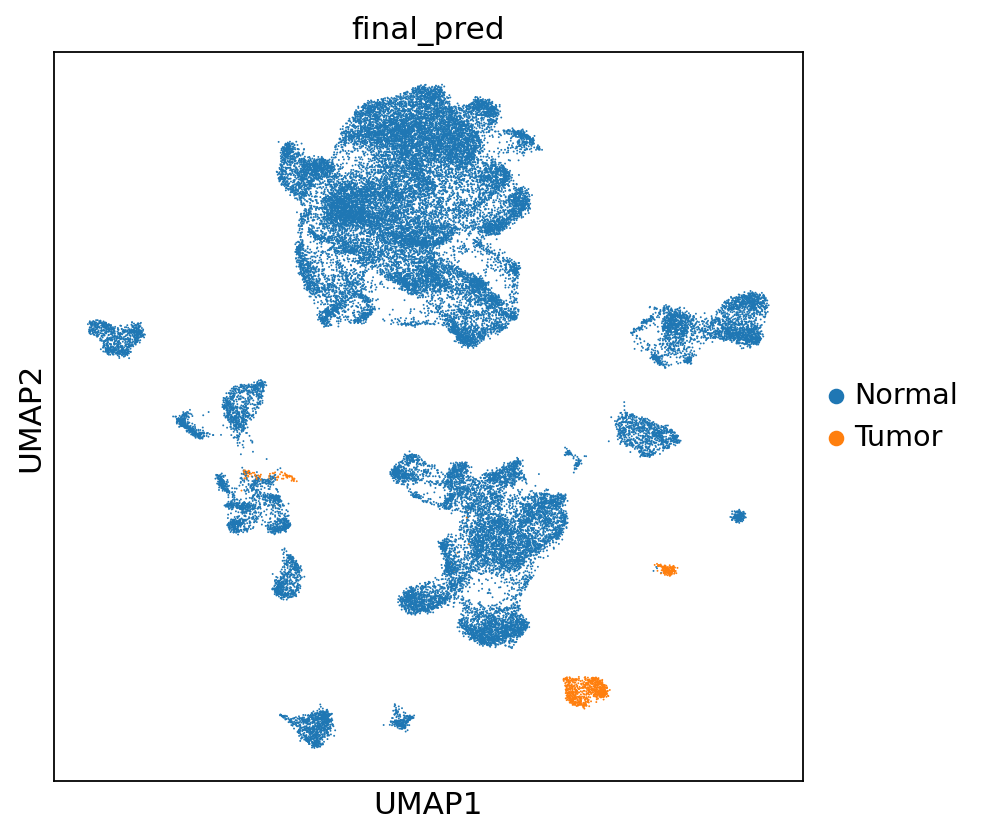

In [70]:
sc.set_figure_params(figsize=(6, 6))
sc.pl.umap(adata_laughney, color=['final_pred'])

Which leaves us with n cancer cells...

### Asses prediction

In [71]:
print((adata_laughney.obs['final_pred'] == 'Tumor').sum())
print((adata_laughney.obs['tier_0_hallmark_corrected'] == 'Tumor').sum())

955
1091


In [21]:
from sklearn.metrics import confusion_matrix

In [22]:
confusion_matrix(adata_laughney.obs['tier_0_hallmark_corrected'],
                 adata_laughney.obs['final_pred'])

array([[38845,   569],
       [  705,   386]])

              precision    recall  f1-score   support

      Normal       0.98      0.99      0.98     39414
       Tumor       0.40      0.35      0.38      1091

    accuracy                           0.97     40505
   macro avg       0.69      0.67      0.68     40505
weighted avg       0.97      0.97      0.97     40505



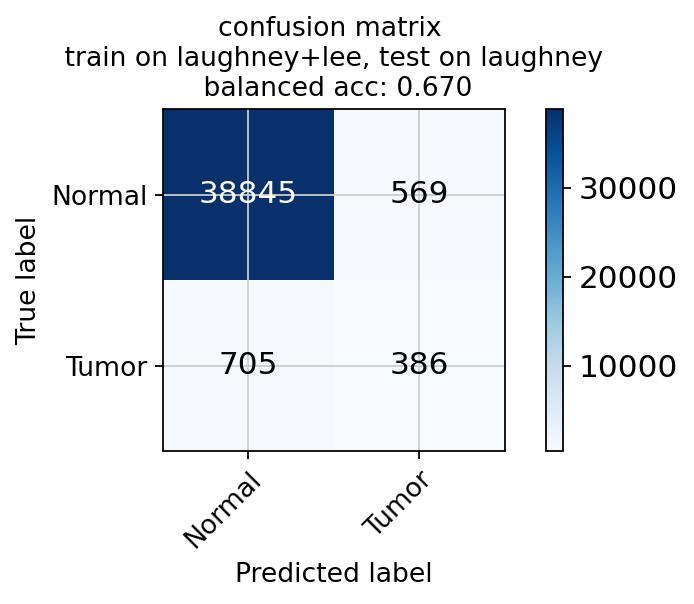

In [23]:
y = adata_laughney.obs['tier_0_hallmark_corrected']
y_pred_lr = adata_laughney.obs['final_pred']
acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=["Normal", "Tumor"]))
fig, ax = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=["Normal", "Tumor"],
    title=f"confusion matrix \n train on laughney+lee, test on laughney \n balanced acc: {acc:.3f}",
)
fig.tight_layout()



We can see that even though the accuracy is very high, the precision for classifying tumor cells is actually very bad.
This may be due to class imbalance, but supposedly, `ikarus` considers that in
A helpful metric for reflecting class imbalance is the $BalancedAccuracy = \frac{TPR + TNR}{2}$

Also this doesn't change if we take the normalization done by ikarus or the one done by the authors.

## InferCNVpy

Let's try with the infercnv package. It is scalable so it must be faster.
First we convert our count matrix to sparse row format to check if it works

In [74]:
adata_laughney.X = adata_laughney.layers['ika_norm']
adata_laughney.X = csr_matrix(adata_laughney.X)

We have to have this columns in the var matrix:

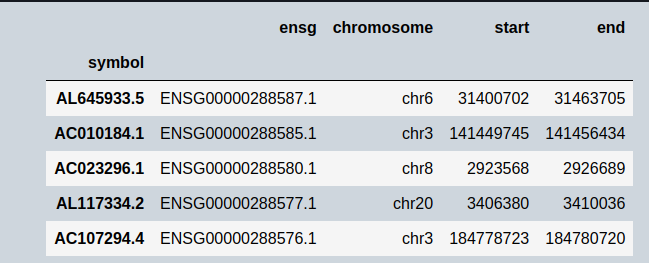

In [34]:
from pybiomart import Server

# Connect to the Ensembl biomart server
server = Server(host='http://www.ensembl.org')

# Select the appropriate dataset (e.g., human genes)
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Prepare the query
# Replace 'your_gene_symbols' with a list of your gene symbols
query = dataset.query(attributes=['external_gene_name', 'chromosome_name', 'start_position', 'end_position'])


# join_map_mart(query, adata_laughney.var , gene_annot='gene_symbol', how='inner')


In [35]:
gene_var = pd.merge(
        pd.DataFrame({'Gene name':adata_laughney.var.index}),
        query,
        how='left', on='Gene name', suffixes=('_xxx','_yyy'))
gene_var

Gene name Chromosome/scaffold name  Gene start (bp)  Gene end (bp)
0          A1BG                       19       58345178.0     58353492.0
1          A1CF                       10       50799409.0     50885675.0
2           A2M                       12        9067664.0      9116229.0
3         A2ML1                       12        8822621.0      8887001.0
4        A4GALT                       22       42692121.0     42721298.0
...         ...                      ...              ...            ...
21472    ZYG11B                        1       52726453.0     52827336.0
21473       ZYX              HG708_PATCH            659.0        10475.0
21474       ZYX                        7      143381295.0    143391111.0
21475     ZZEF1                       17        4004445.0      4143030.0
21476      ZZZ3                        1       77562416.0     77683419.0

[21477 rows x 4 columns]

In [36]:
gene_var.columns = ['Symbol', 'chromosome', 'start', 'end']
gene_var.loc[:,['start','end']] = gene_var.loc[:,['start','end']].astype('Int32')
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
gene_var

Symbol   chromosome      start        end
0        A1BG           19   58345178   58353492
1        A1CF           10   50799409   50885675
2         A2M           12    9067664    9116229
3       A2ML1           12    8822621    8887001
4      A4GALT           22   42692121   42721298
...       ...          ...        ...        ...
21472  ZYG11B            1   52726453   52827336
21473     ZYX  HG708_PATCH        659      10475
21474     ZYX            7  143381295  143391111
21475   ZZEF1           17    4004445    4143030
21476    ZZZ3            1   77562416   77683419

[21477 rows x 4 columns]

Remove the scaffolds and only stay wtih normal chromosomes and integrate into var matrix

In [37]:
gene_var = gene_var.groupby('Symbol')\
    .apply(lambda x: remove_by_str(x))\
    .reset_index(drop=True)
gene_var['chromosome'] = gene_var['chromosome'].astype('category')
# gene_var = gene_var.chromosome

In [38]:
adata_laughney.var = gene_var
adata_laughney.var

Symbol chromosome      start        end
0        A1BG         19   58345178   58353492
1        A1CF         10   50799409   50885675
2         A2M         12    9067664    9116229
3       A2ML1         12    8822621    8887001
4      A4GALT         22   42692121   42721298
...       ...        ...        ...        ...
19217  ZYG11A          1   52842511   52894998
19218  ZYG11B          1   52726453   52827336
19219     ZYX          7  143381295  143391111
19220   ZZEF1         17    4004445    4143030
19221    ZZZ3          1   77562416   77683419

[19222 rows x 4 columns]

In [39]:
adata_laughney.var.index = adata_laughney.var.Symbol
del adata_laughney.var['Symbol']
adata_laughney.var

chromosome      start        end
Symbol                                 
A1BG           19   58345178   58353492
A1CF           10   50799409   50885675
A2M            12    9067664    9116229
A2ML1          12    8822621    8887001
A4GALT         22   42692121   42721298
...           ...        ...        ...
ZYG11A          1   52842511   52894998
ZYG11B          1   52726453   52827336
ZYX             7  143381295  143391111
ZZEF1          17    4004445    4143030
ZZZ3            1   77562416   77683419

[19222 rows x 3 columns]

`inferncvpy` expects the names of the chromosmes to start with 'chr' else
it will not cpature them.

In [40]:
adata_laughney.var['chromosome'] = ['chr'+str(i) for i in adata_laughney.var['chromosome']]

### Calculation

In [75]:
%%time
# We could provide all immune cell types as "normal cells". with the reference_cat param
cnv.tl.infercnv(
    adata_laughney,
    reference_key="CELL_TYPE",
    reference_cat=[
        'Breg', 'DENDRITIC', 'DENDRITIC (ACTIVATED)', 'Tm', 'Th', 'Treg', 'NK', 'NKT', 'MICROGLIA/MACROPHAGE', 'MDSC', 'MONOCYTE'
    ],
    window_size=250,
)

  0%|          | 0/9 [00:00<?, ?it/s]

CPU times: user 10.4 s, sys: 25 s, total: 35.5 s
Wall time: 1min


In [73]:
adata_laughney.obsm['X_cnv']

<40505x1836 sparse matrix of type '<class 'numpy.float64'>'
	with 3815145 stored elements in Compressed Sparse Row format>

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


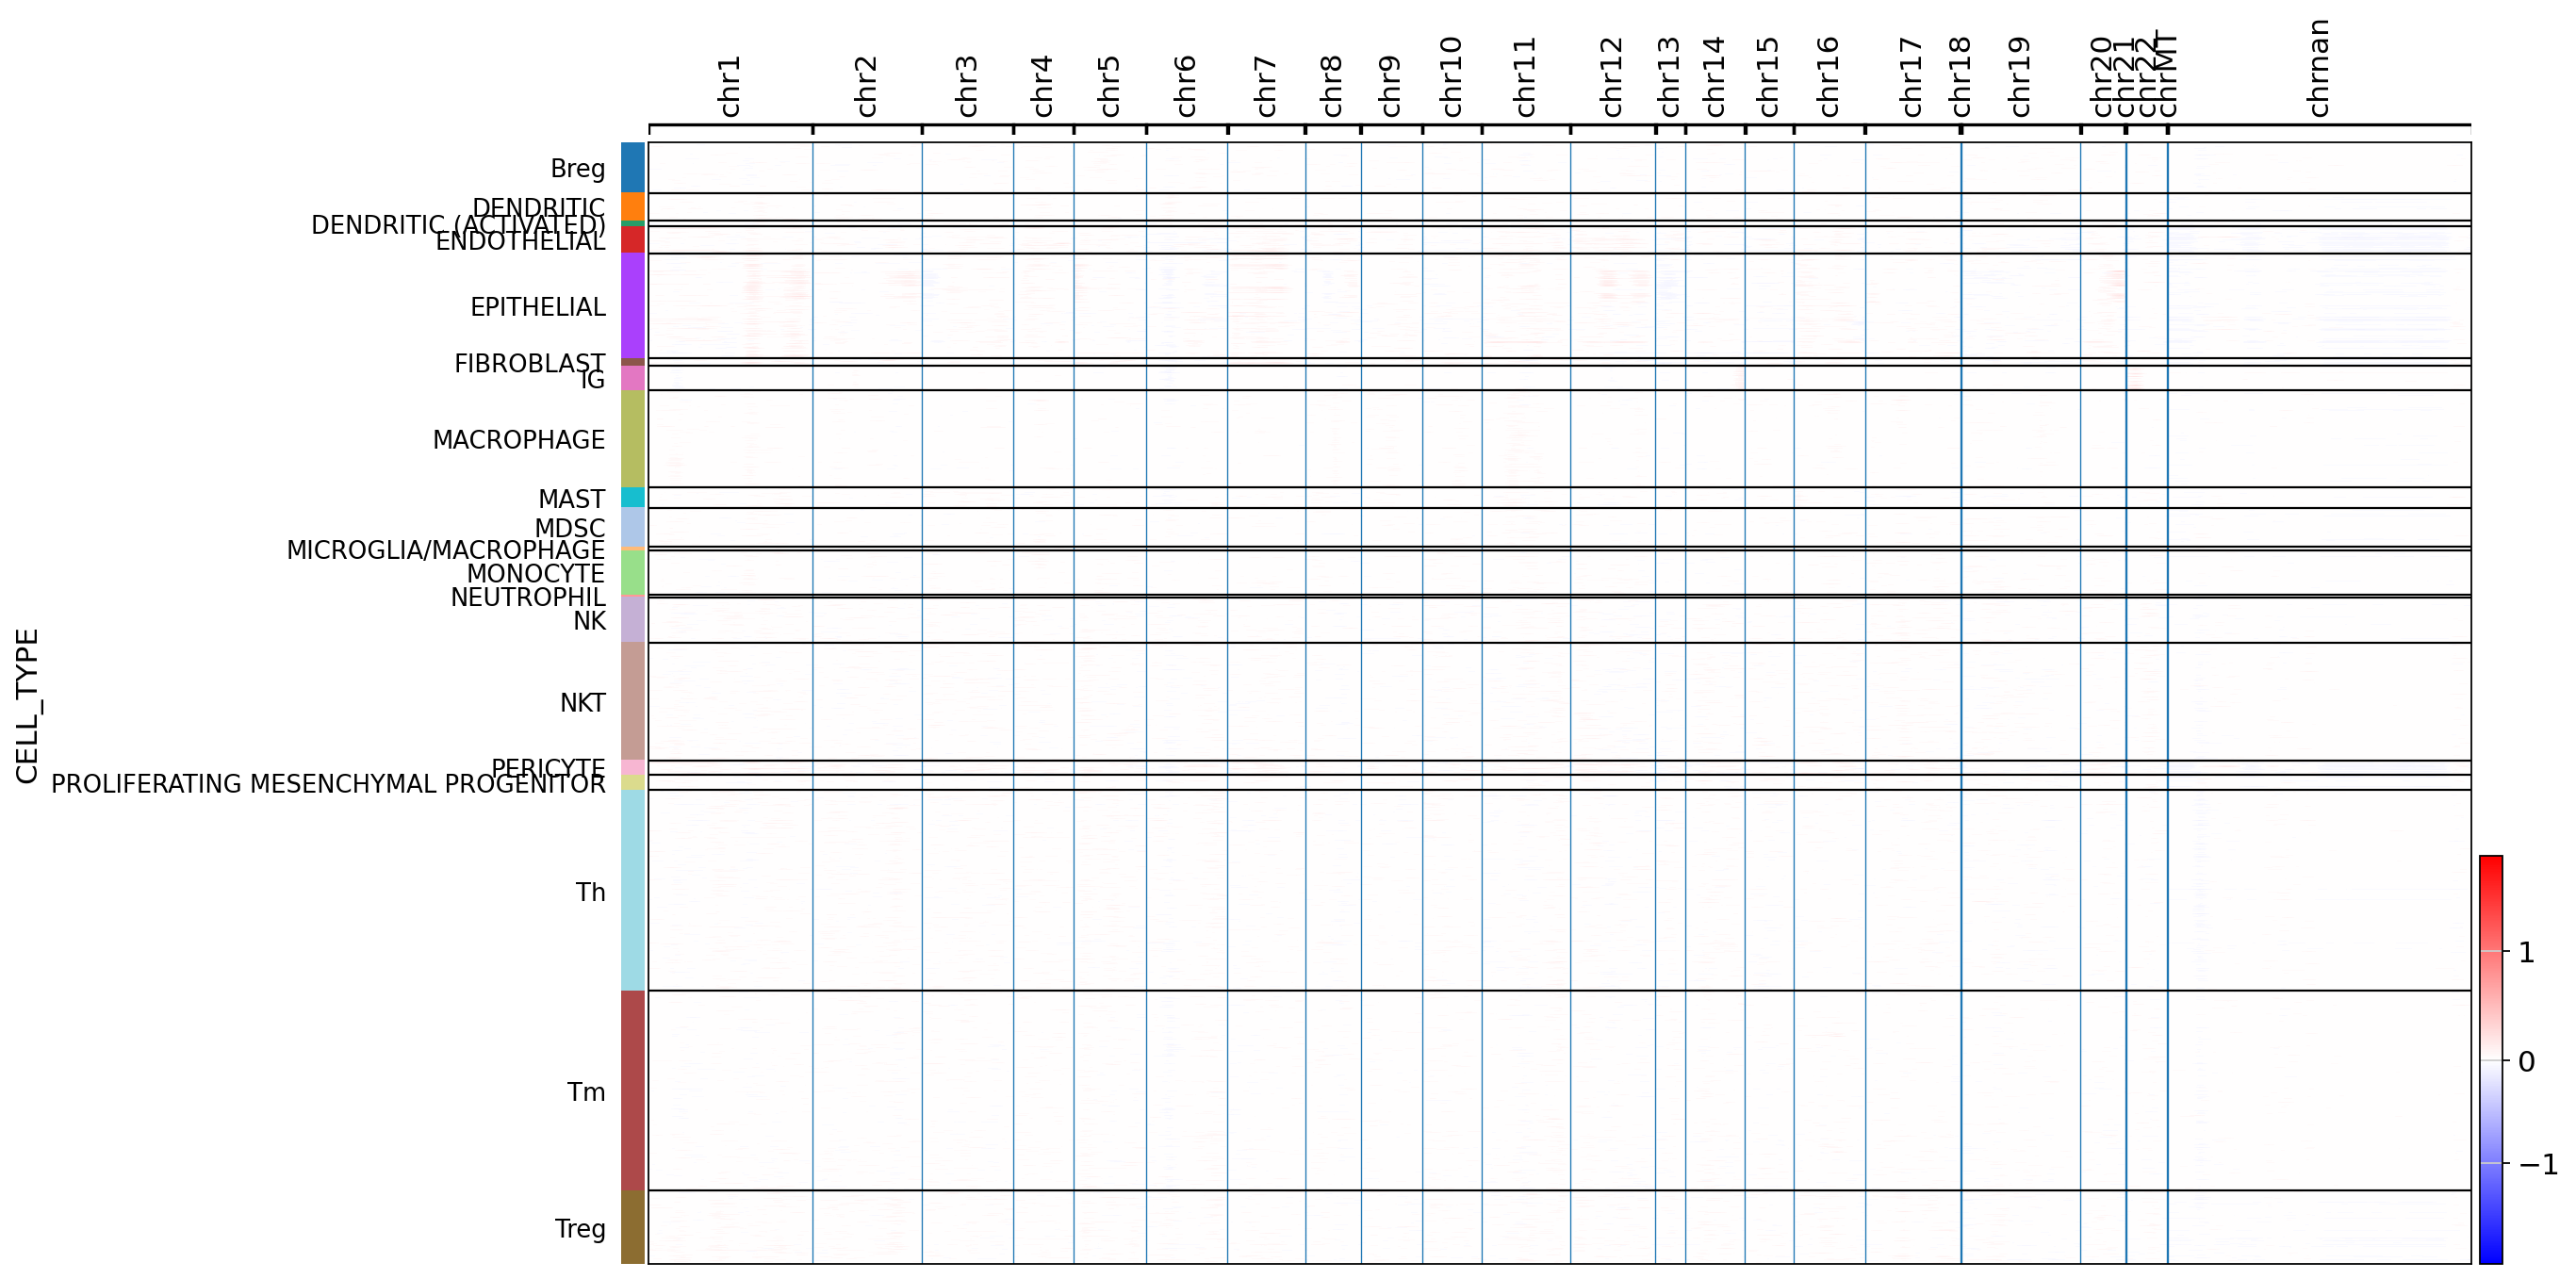

In [76]:
cnv.pl.chromosome_heatmap(adata_laughney, groupby="CELL_TYPE")

In [77]:
cnv.tl.pca(adata_laughney)
cnv.pp.neighbors(adata_laughney)
cnv.tl.leiden(adata_laughney)

/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [475]:
adata_laughney

AnnData object with n_obs × n_vars = 40505 × 19222
    obs: 'Sample ID', 'Legend', 'Cell ID', 'CELL_TYPE', 'Meta-Source', 'META_CELL_TYPE', 'PHENOGRAPH_CLASS', 'ascend', 'tier_0_hallmark_corrected', 'core_pred', 'final_pred', 'cnv_leiden', 'cnv_score'
    var: 'chromosome', 'start', 'end'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'final_pred_colors', 'cnv', 'CELL_TYPE_colors', 'cnv_neighbors', 'leiden', 'cnv_leiden_colors', 'dendrogram_cnv_leiden'
    obsm: 'X_pca', 'X_umap', 'X_cnv', 'X_cnv_pca', 'X_cnv_umap'
    varm: 'PCs'
    layers: 'counts', 'ika_norm'
    obsp: 'distances', 'connectivities', 'cnv_neighbors_distances', 'cnv_neighbors_connectivities'

In [481]:
del adata_laughney.uns['dendrogram_cnv_leiden']

In [78]:
sc.tl.dendrogram(adata_laughney, groupby='cnv_leiden')

/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


categories: 0, 1, 2, etc.
var_group_labels: chr1, chr2, chr3, etc.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):


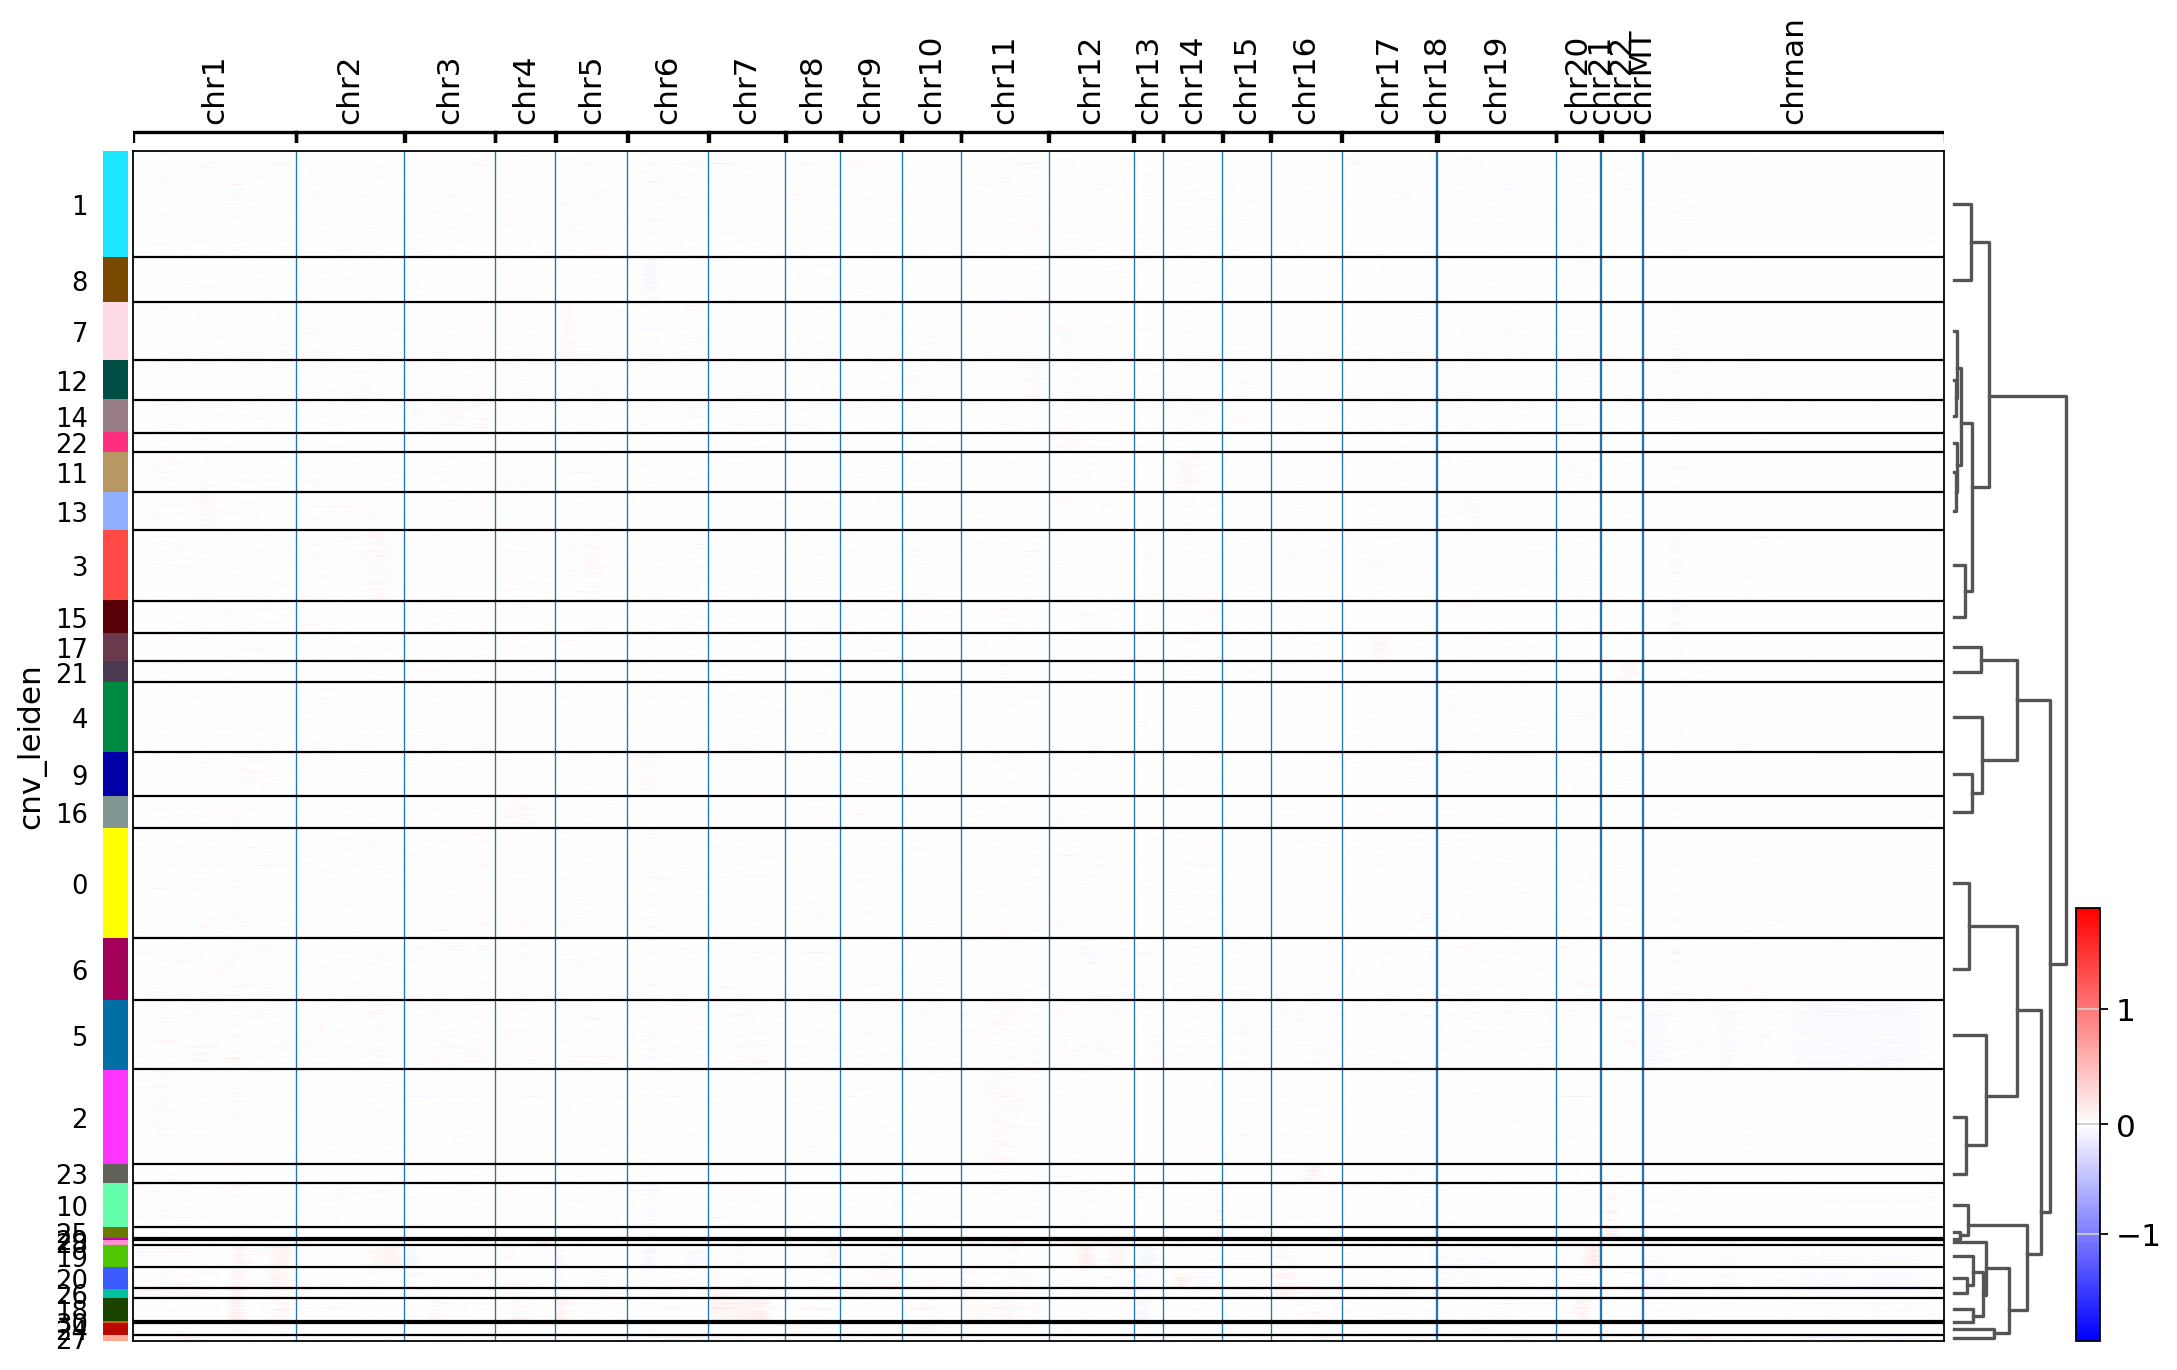

In [79]:
cnv.pl.chromosome_heatmap(adata_laughney, groupby="cnv_leiden", dendrogram=True)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/usr/local/lib/python3.11/site-packages/scanpy/plotting/_anndata.py:1067: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if isinstance(groupby, str) and is_categorical_dtype(adata.obs[groupby]):
/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:105: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(adata.obs[group]):
/usr/local/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


categories: 0, 1, 2, etc.
var_group_labels: chrchr1, chrchr2, chrchr3, etc.


/usr/local/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:133: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_df = rep_df.groupby(level=0).mean()


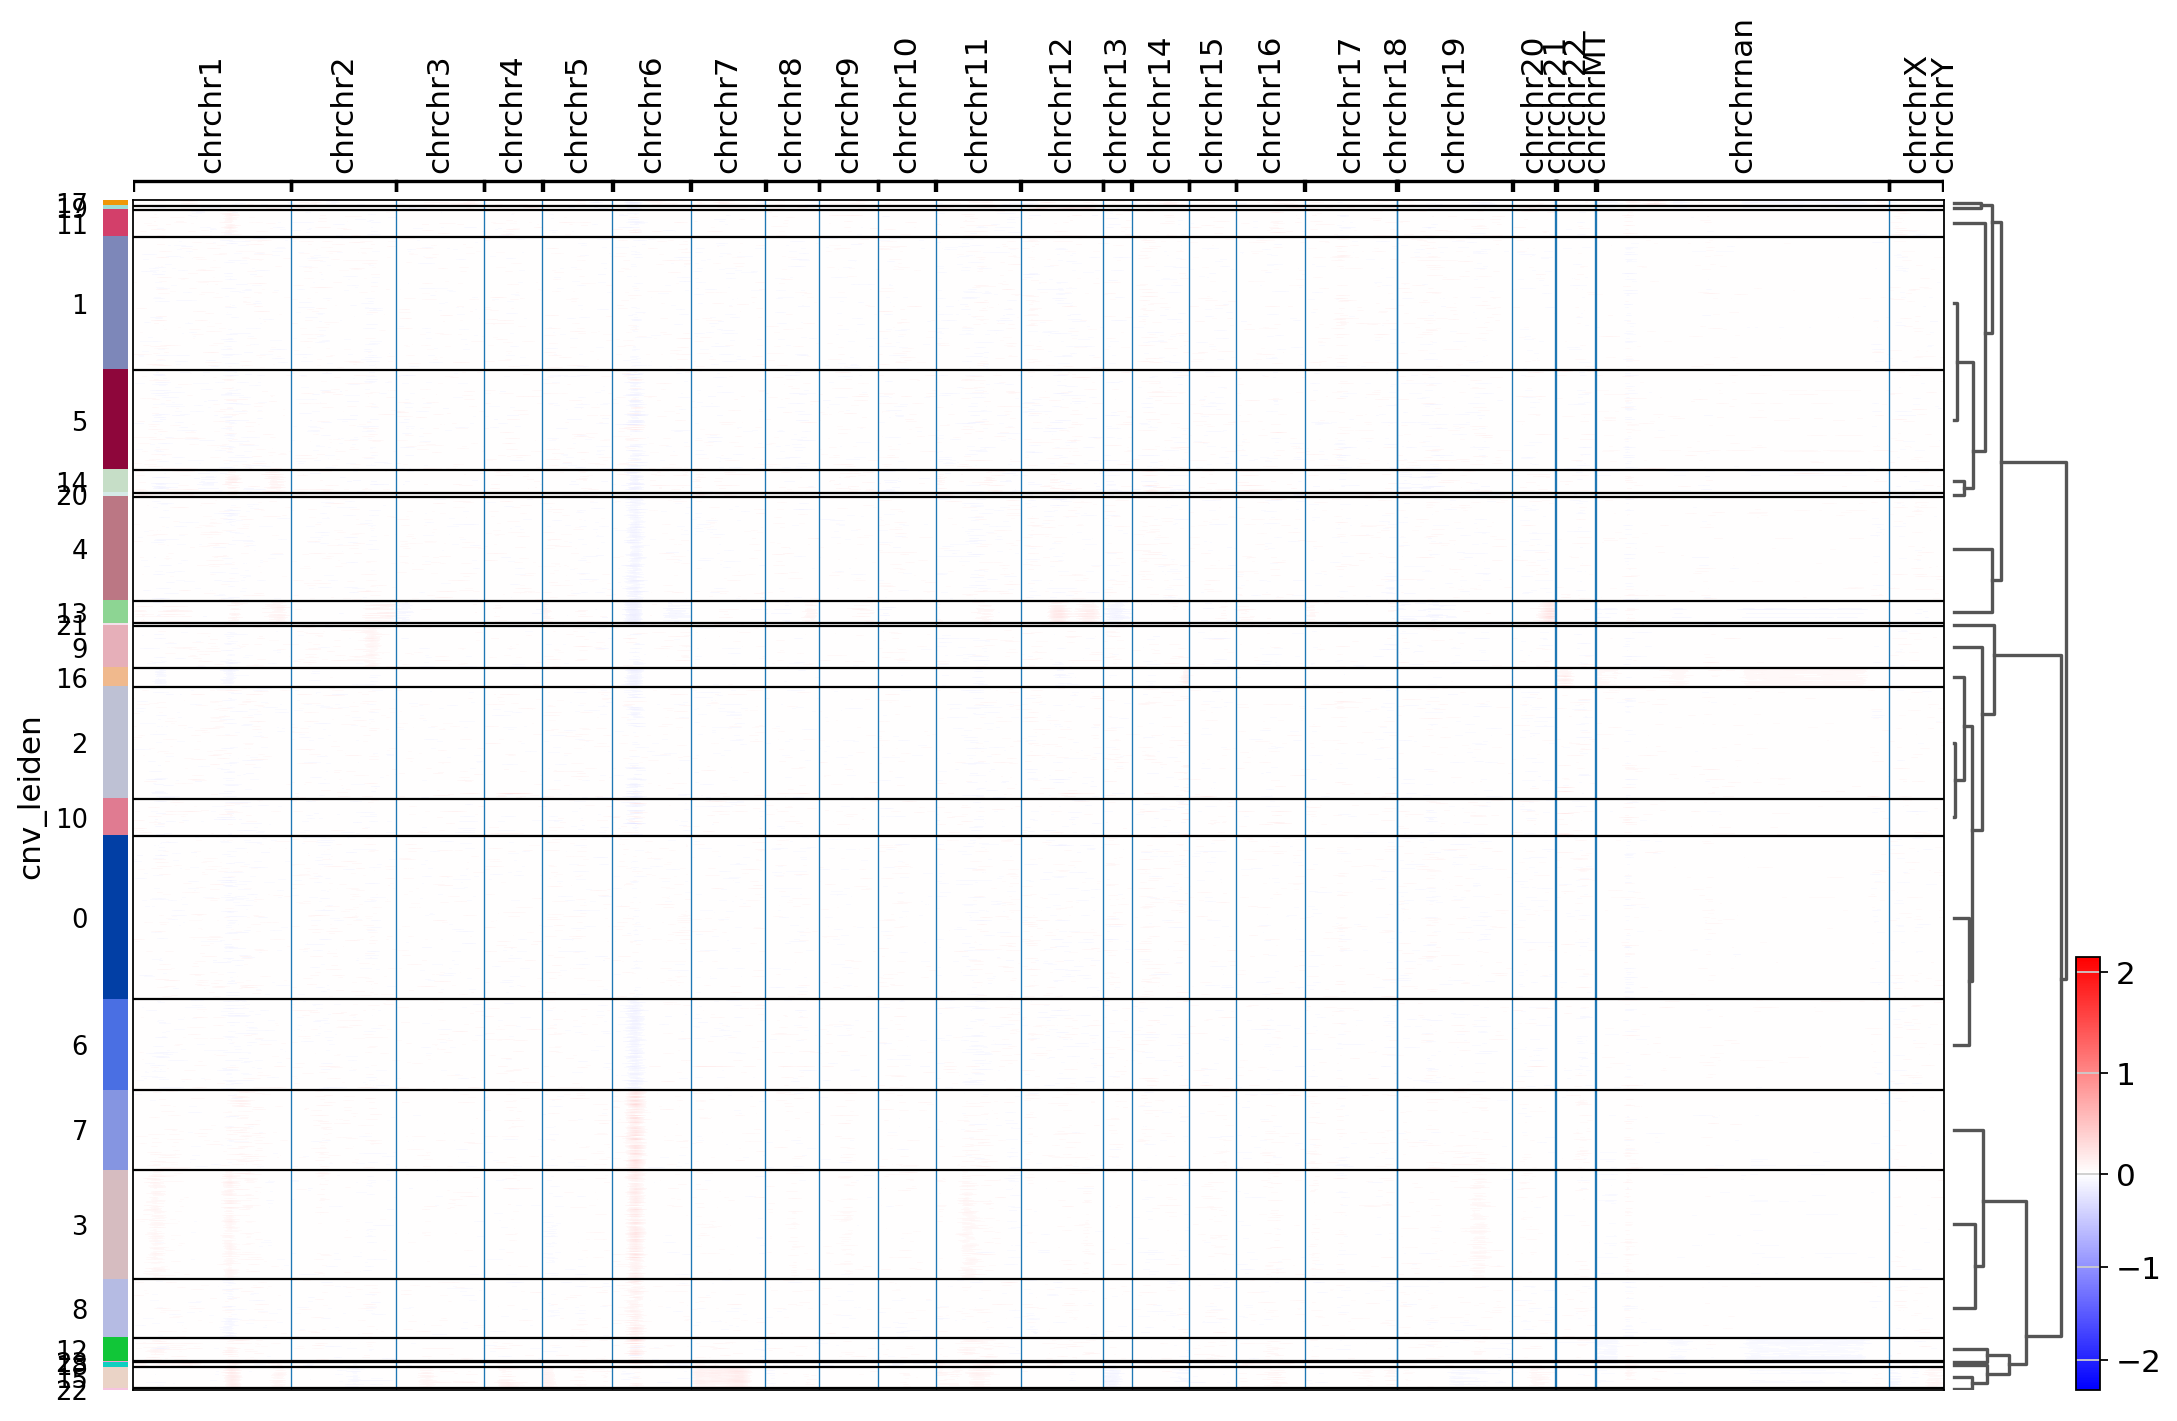

In [459]:
cnv.pl.chromosome_heatmap(adata_laughney, groupby="cnv_leiden", dendrogram=True)

### UMAP plot of CNV profiles

In [80]:
cnv.tl.umap(adata_laughney)
cnv.tl.cnv_score(adata_laughney)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


<Axes: title={'center': 'cnv_score'}, xlabel='cnv_umap1', ylabel='cnv_umap2'>

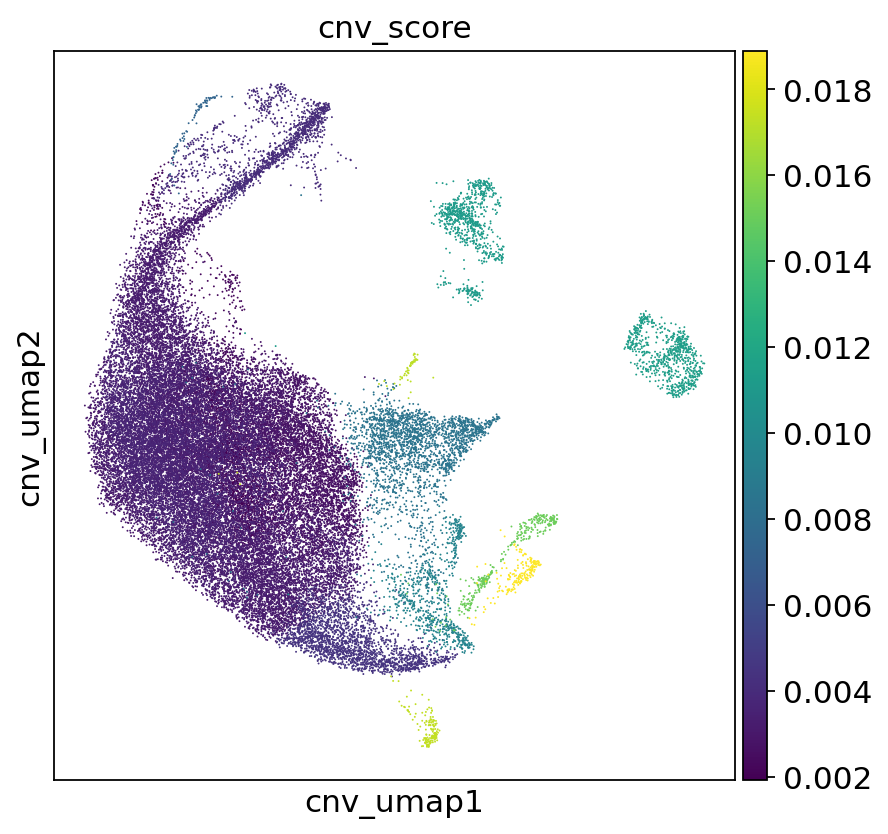

In [81]:
cnv.pl.umap(adata_laughney, color="cnv_score", show=False)

... storing 'chromosome' as categorical
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):


<Axes: title={'center': 'cnv_score'}, xlabel='cnv_umap1', ylabel='cnv_umap2'>

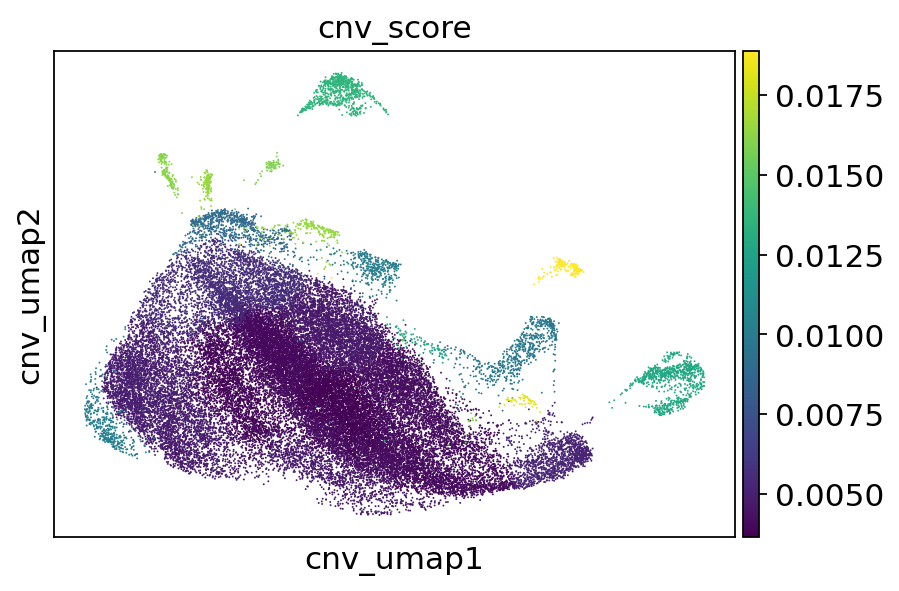

In [461]:
cnv.pl.umap(adata_laughney, color="cnv_score", show=False)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

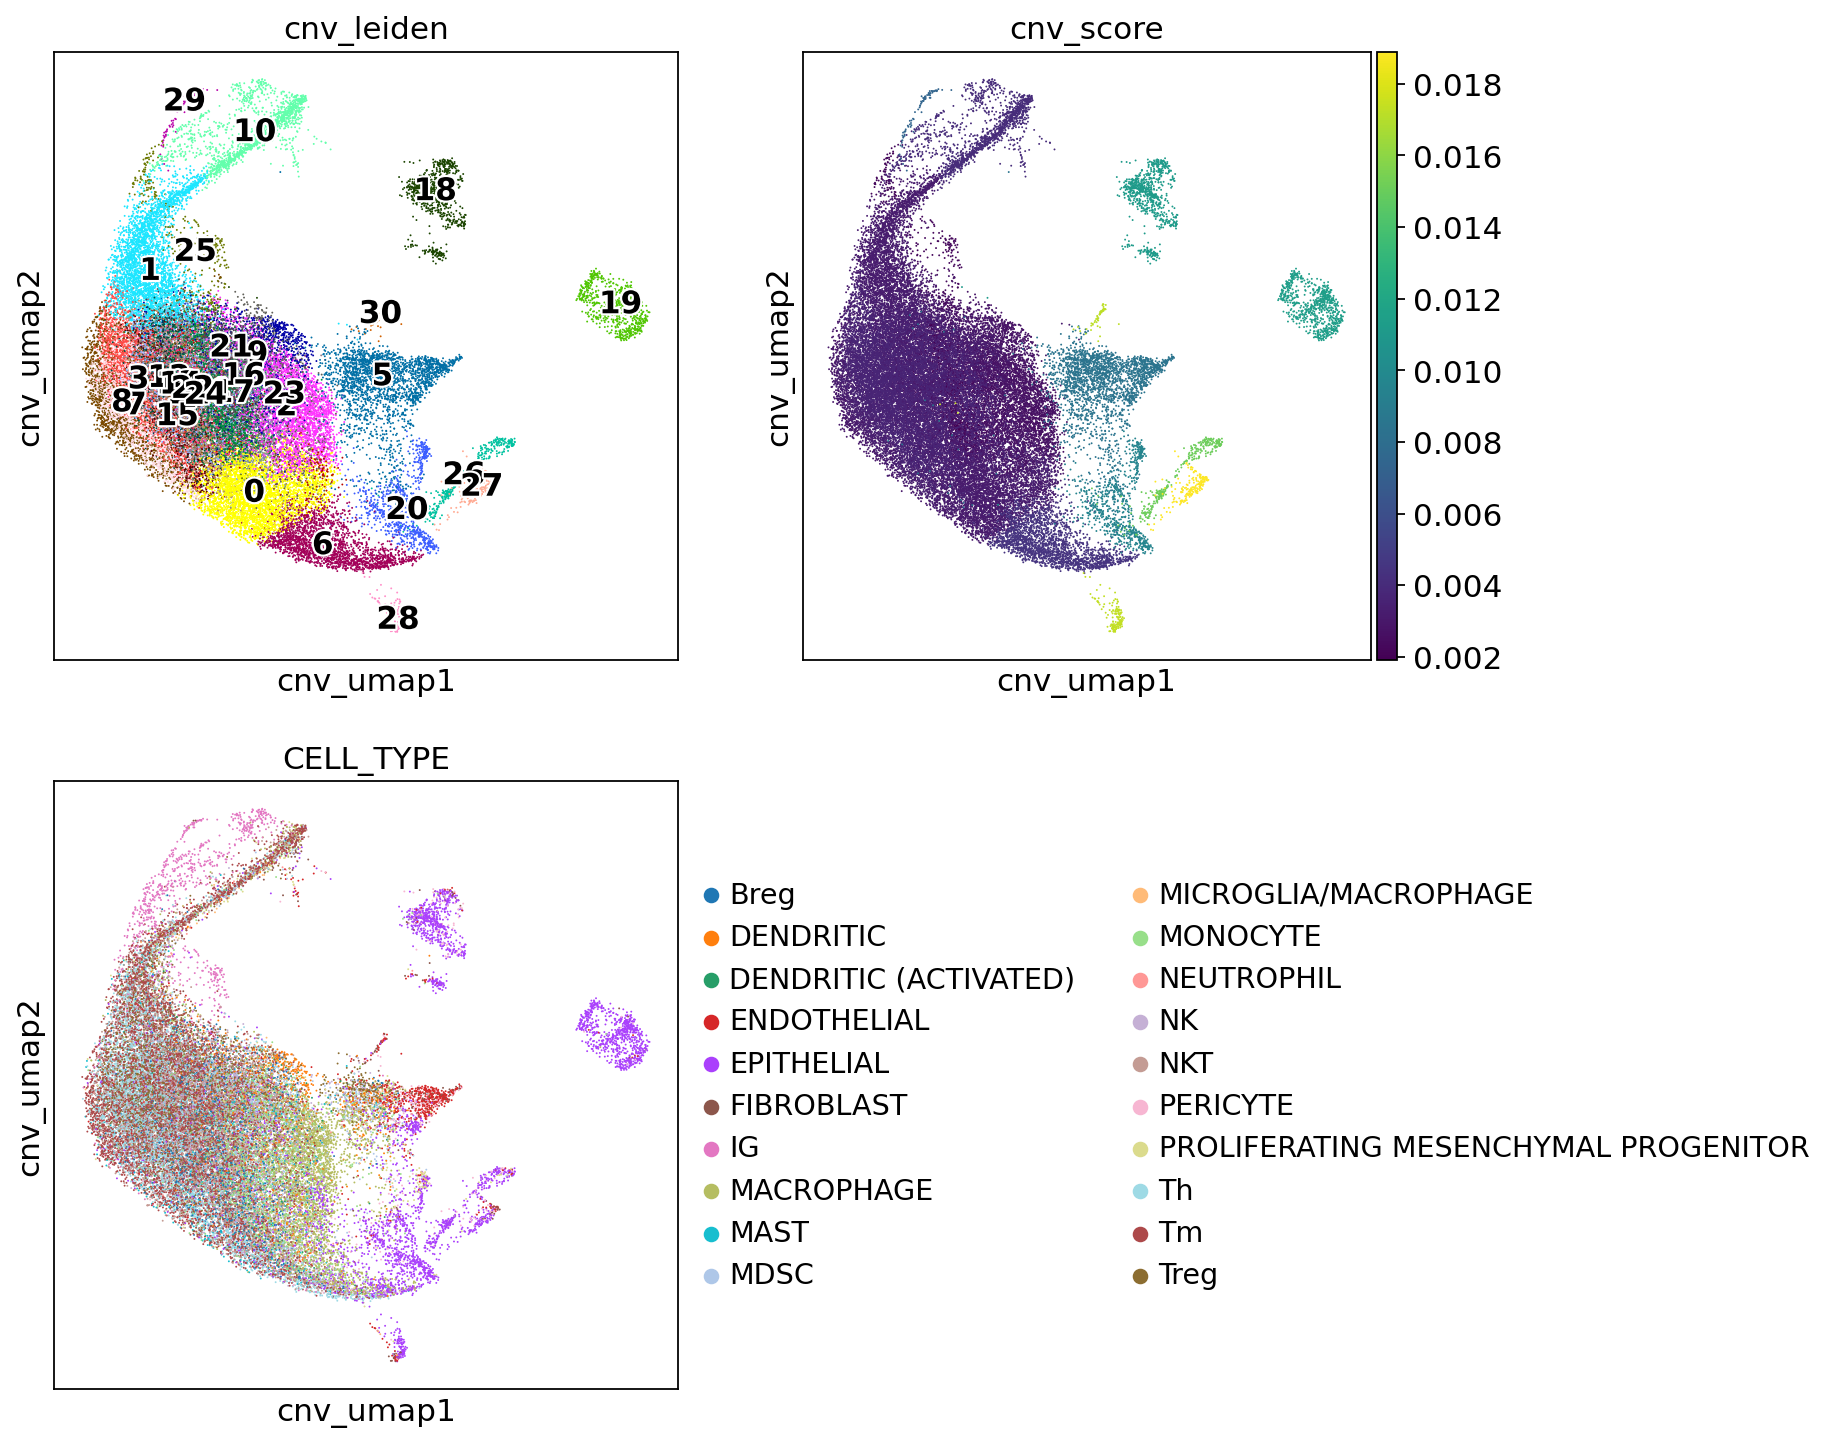

In [82]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata_laughney,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata_laughney, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata_laughney, color="CELL_TYPE", ax=ax3)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

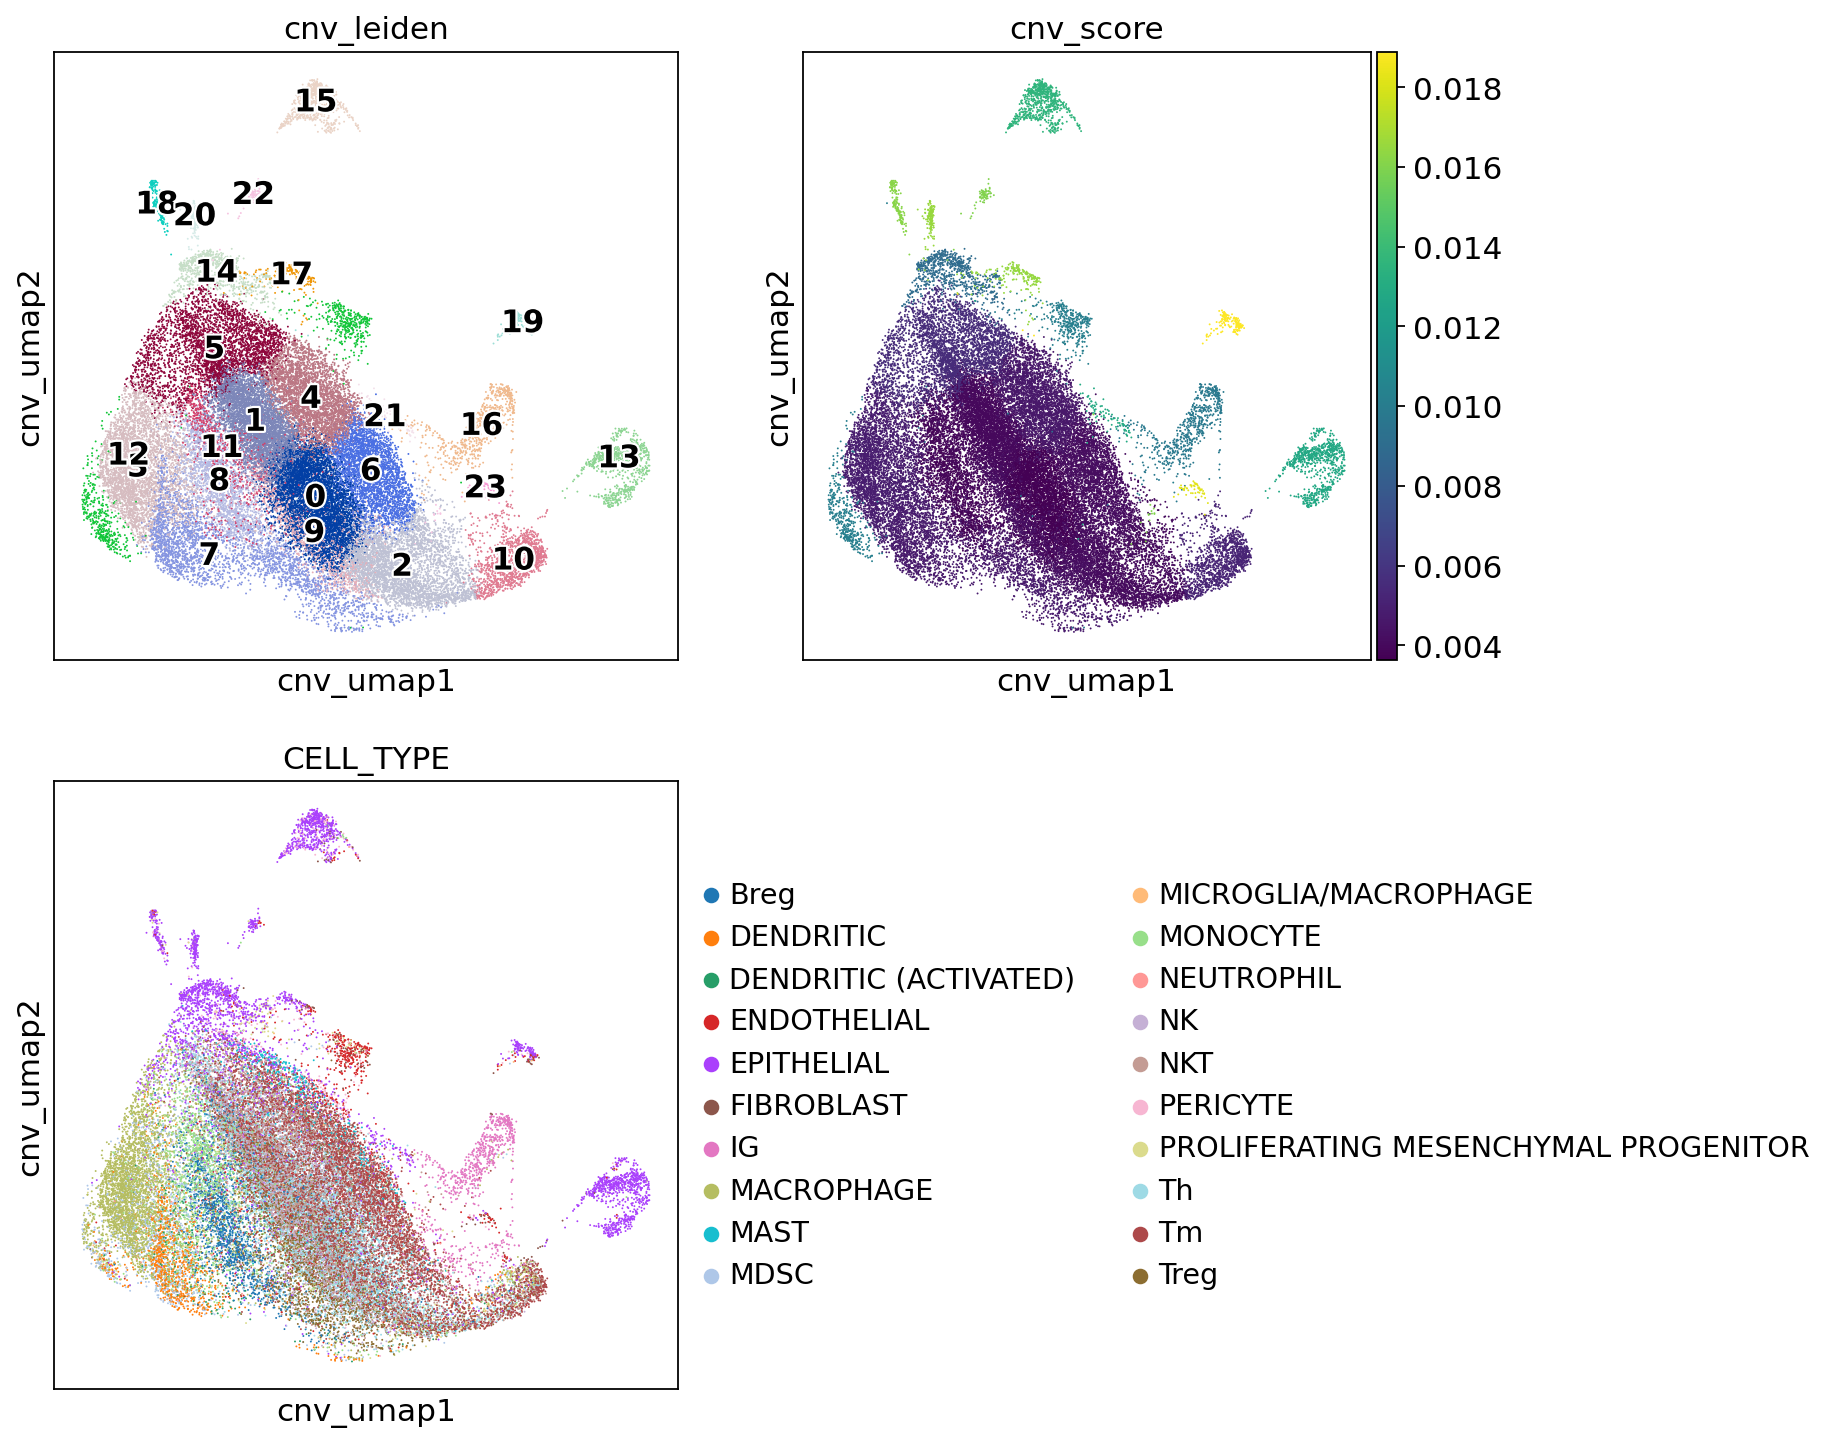

In [462]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(11, 11))
ax4.axis("off")
cnv.pl.umap(
    adata_laughney,
    color="cnv_leiden",
    legend_loc="on data",
    legend_fontoutline=2,
    ax=ax1,
    show=False,
)
cnv.pl.umap(adata_laughney, color="cnv_score", ax=ax2, show=False)
cnv.pl.umap(adata_laughney, color="CELL_TYPE", ax=ax3)

We can also visualize the CNV score and clusters on the transcriptomics-based UMAP plot. Again, we can see that there are subclusters of epithelial cells that belong to a distinct CNV cluster, and that these clusters tend to have the highest CNV score.

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

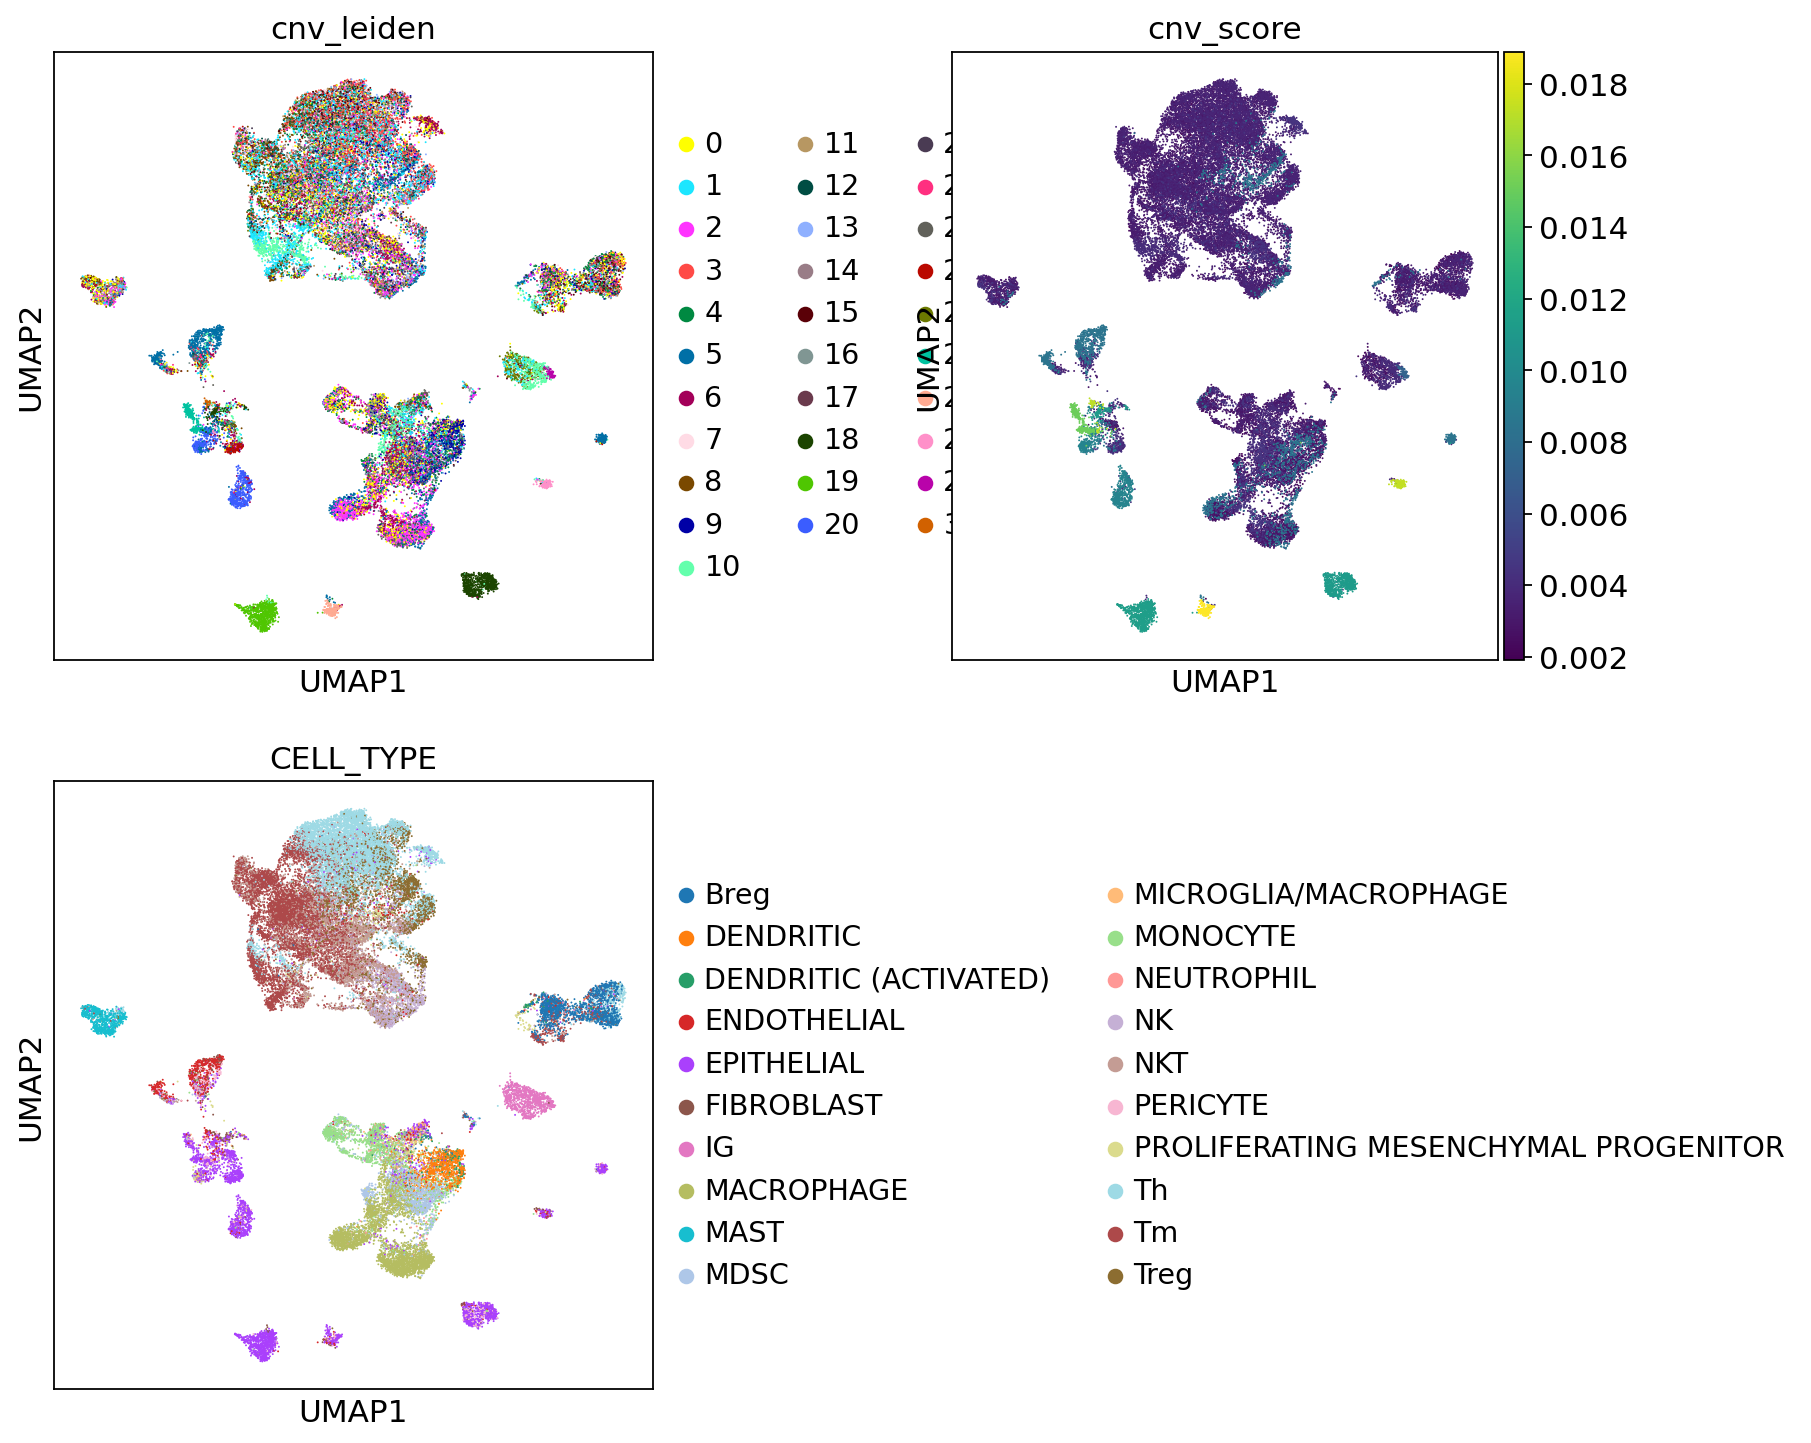

In [84]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata_laughney, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata_laughney, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata_laughney, color="CELL_TYPE", ax=ax3)

/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if not is_categorical_dtype(values):
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1216: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/usr/local/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1207: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future ve

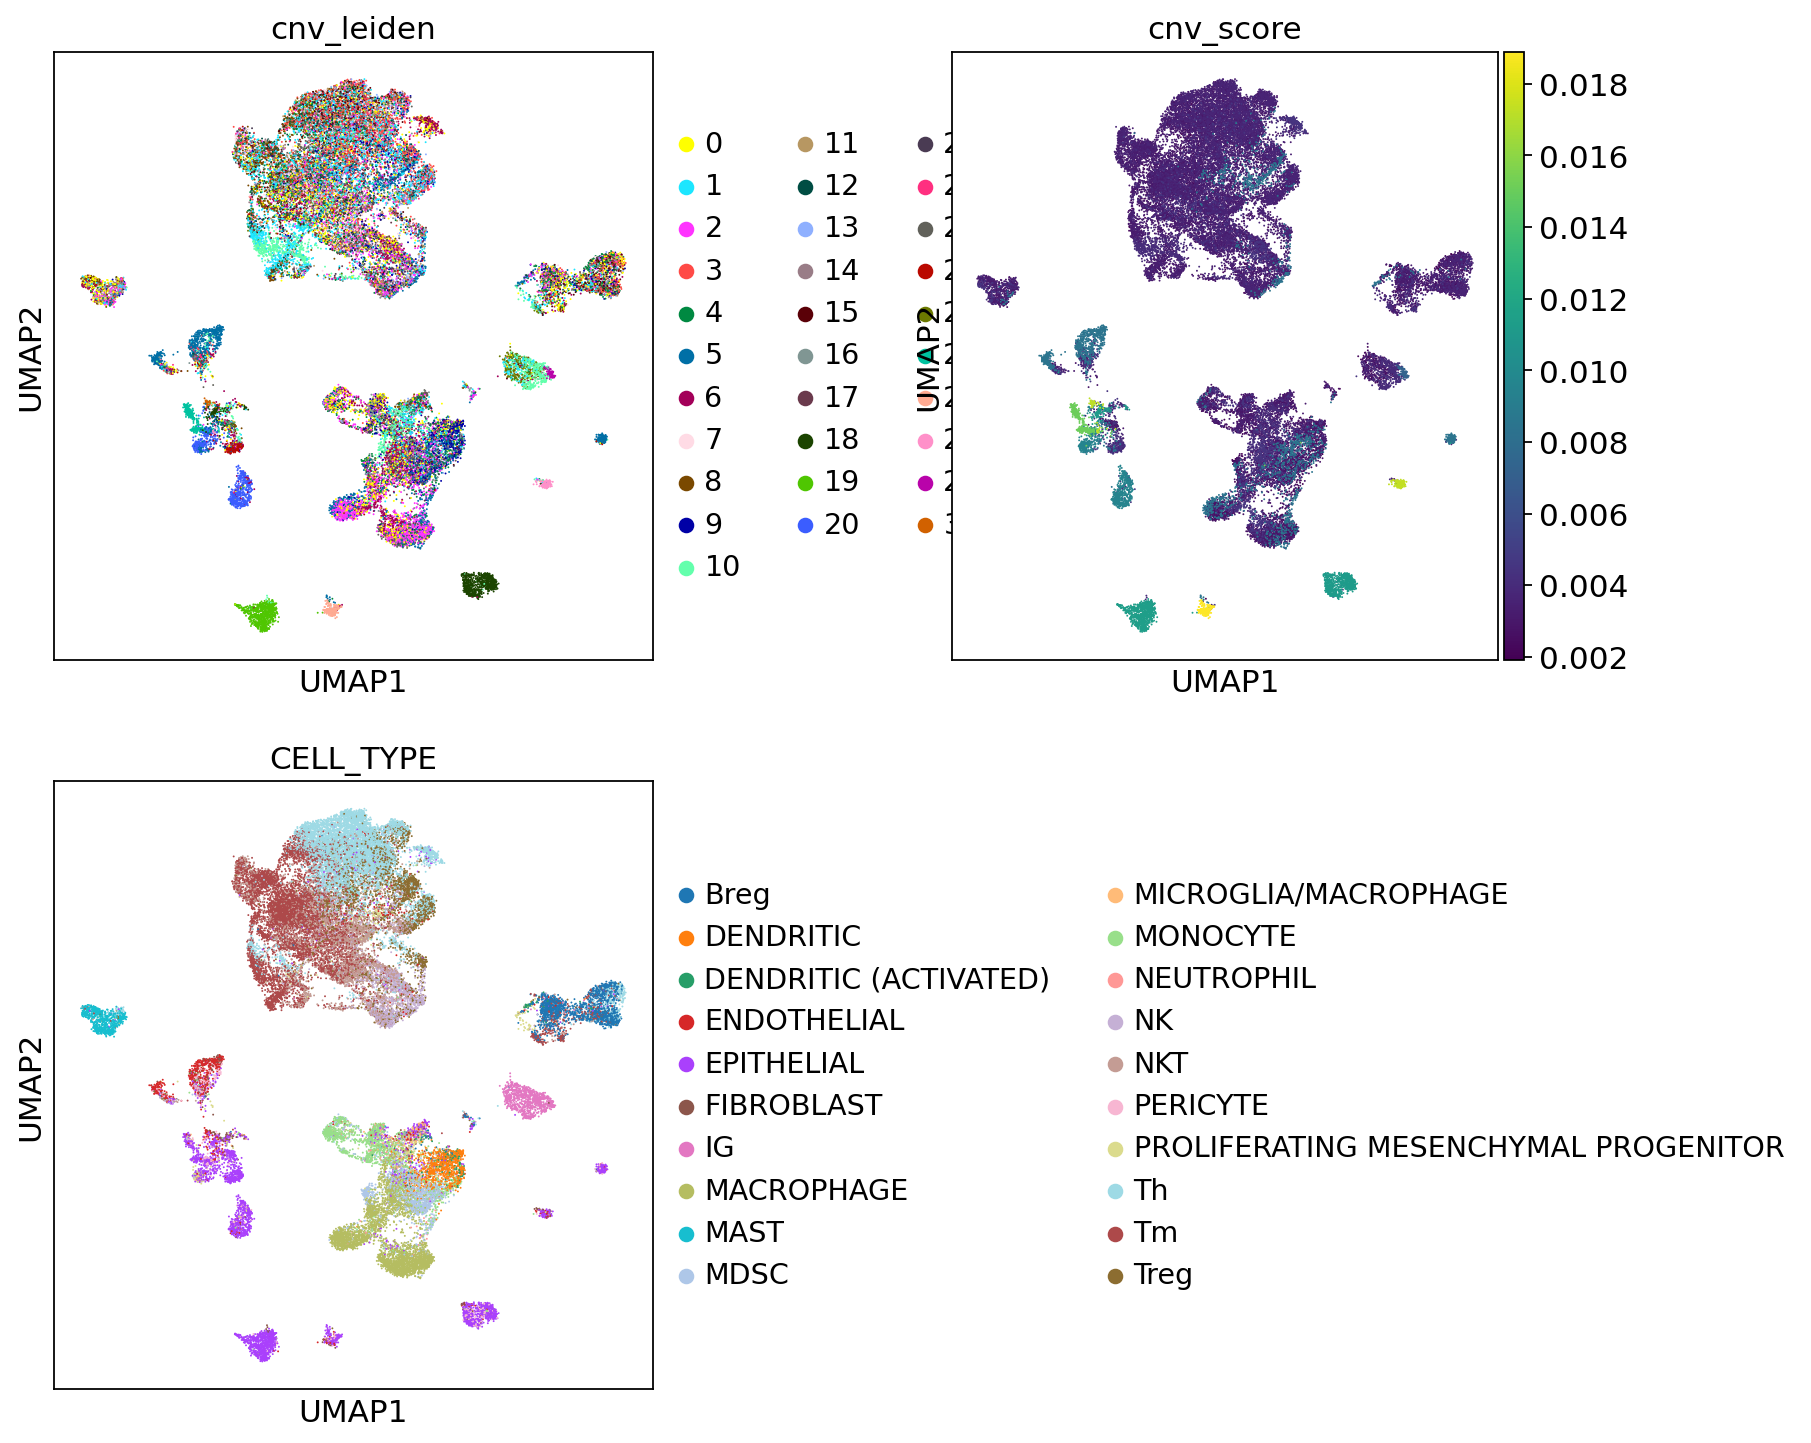

In [83]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 11), gridspec_kw=dict(wspace=0.5)
)
ax4.axis("off")
sc.pl.umap(adata_laughney, color="cnv_leiden", ax=ax1, show=False)
sc.pl.umap(adata_laughney, color="cnv_score", ax=ax2, show=False)
sc.pl.umap(adata_laughney, color="CELL_TYPE", ax=ax3)

### Classifying tumor cells

Convert the start and end loci into floats with nans

In [975]:
for col in adata_laughney.obs.columns:
    # if adata_laughney.obs[col].dtype == 'category':
    #     adata_laughney.obs[col] = adata_laughney.obs[col].astype(str)
        
    adata_laughney.obs.loc[adata_laughney.obs[col].isna(), col] = np.nan
        
for col in adata_laughney.var.columns:
    # if adata_laughney.var[col].dtype == 'category':
    #     adata_laughney.var[col] = adata_laughney.var[col].astype(str)
        
    adata_laughney.var.loc[adata_laughney.var[col].isna(), col] = np.nan
    
adata_laughney.var.start = adata_laughney.var.start.astype(float)
adata_laughney.var.end = adata_laughney.var.end.astype(float)

In [976]:
adata_laughney.var.start[adata_laughney.var.start.isna()][0]

/tmp/ipykernel_11078/2633839700.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  adata_laughney.var.start[adata_laughney.var.start.isna()][0]


nan

In [5]:
adata_laughney.write_h5ad(f'{data_dir}/laughney_cnvs.h5ad')
# adata_laughney = sc.read_h5ad(f'{data_dir}/laughney_cnvs.h5ad')

In [762]:
cnvs = pd.DataFrame(adata_laughney.obs.cnv_score)
cnvs.cnv_score

adata_laughney.var['gene_symbol'] = adata_laughney.var.index

First we try out the automatic correction with use of cnvs that comes with `ikarus`.

In [518]:
final_cnv_correct = model.cnv_correct(cnvs, adata_laughney, 'laughney')
final_cnv_correct_net = model.cnv_correct(cnvs, adata_laughney, 'laughney', label_propagation=True)

/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:215: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/usr/local/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:539: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns['hvg'] = {'flavor': flavor}


converged at iteration step: 2 with 0.0000 < 0.001


In [658]:
print(np.unique(final_cnv_correct))
print(final_cnv_correct_net.unique())

['Normal']
['Normal']


We can see that it reclassifies all the cells as normal. Let's find out why it does that.

In the tutorial we can see that they do a logistic regression with the cnv scores for 
tumor cells and for normal cells.

I still don't know how they got the normal ones. Probably with cnv optimization for specific clusters,
but I haven't found out how to program `infercnv` to seprate those cnvs. So
we wull just use the stragihtforward `cnv_scores`.


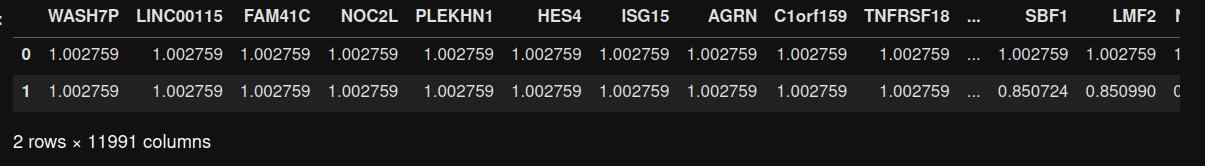

In the article for `ikarus`, they mention that they do a logistic regression on with
with the cnv scores as **covariates** and the expertly annotated cells as predictors.
So let's see how that would look like:

In [659]:
from sklearn.linear_model import LogisticRegression

In [787]:
X_train = cnvs.values.copy()
y_train = adata_laughney.obs['final_pred'].values.copy()
y_train = np.where(y_train == 'Tumor', 1, 0)

print(len(y_train))
len(y_train) - y_train.sum()

40505


39550

Input clustered values to test the regression

In [786]:
print(len(X_train[y_train == 1]))

center = X_train.max() + 0.4*X_train.max()  # The specific number around which values are centered
range_width = 0.1*X_train.max()  # Width of the range around the center
size = len(X_train[y_train == 1])  # Number of values

lower_bound = center - range_width / 2
upper_bound = center + range_width / 2

values = np.random.uniform(lower_bound, upper_bound, size)
X_train[y_train == 1] = values.reshape(955,1)

955


In [769]:
# Normalize the vector
X_train = X_train / X_train.max()


solver : {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, \
            default='lbfgs'

        Algorithm to use in the optimization problem. Default is 'lbfgs'.
        To choose a solver, you might want to consider the following aspects:

            - For small datasets, 'liblinear' is a good choice, whereas 'sag'
              and 'saga' are faster for large ones;
            - For multiclass problems, only 'newton-cg', 'sag', 'saga' and
              'lbfgs' handle multinomial loss;
            - 'liblinear' is limited to one-versus-rest schemes.
            - 'newton-cholesky' is a good choice for `n_samples` >> `n_features`,
              especially with one-hot encoded categorical features with rare
              categories. Note that it is limited to binary classification and the
              one-versus-rest reduction for multiclass classification. Be aware that
              the memory usage of this solver has a quadratic dependency on
              `n_features` because it explicitly computes the Hessian matrix.


In [788]:
model_ = LogisticRegression(max_iter=1000,
                            solver='newton-cholesky'
                           )
model_.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='newton-cholesky')

In [789]:
# Create a meshgrid for plotting
x_min, x_max = X_train[:, 0].min(), X_train[:, 0].max()
xx = np.arange(x_min, x_max, 0.0007).reshape(-1,1)
x_values = xx

# predict proba
probabilities = model_.predict_proba(x_values)[:,1]  # Probability for class 1



In [790]:
probabilities = np.log(probabilities/(1- probabilities))
y_train =np.log(y_train/(1-y_train))

/tmp/ipykernel_11078/1569445780.py:2: RuntimeWarning: divide by zero encountered in divide
  y_train =np.log(y_train/(1-y_train))
/tmp/ipykernel_11078/1569445780.py:2: RuntimeWarning: divide by zero encountered in log
  y_train =np.log(y_train/(1-y_train))


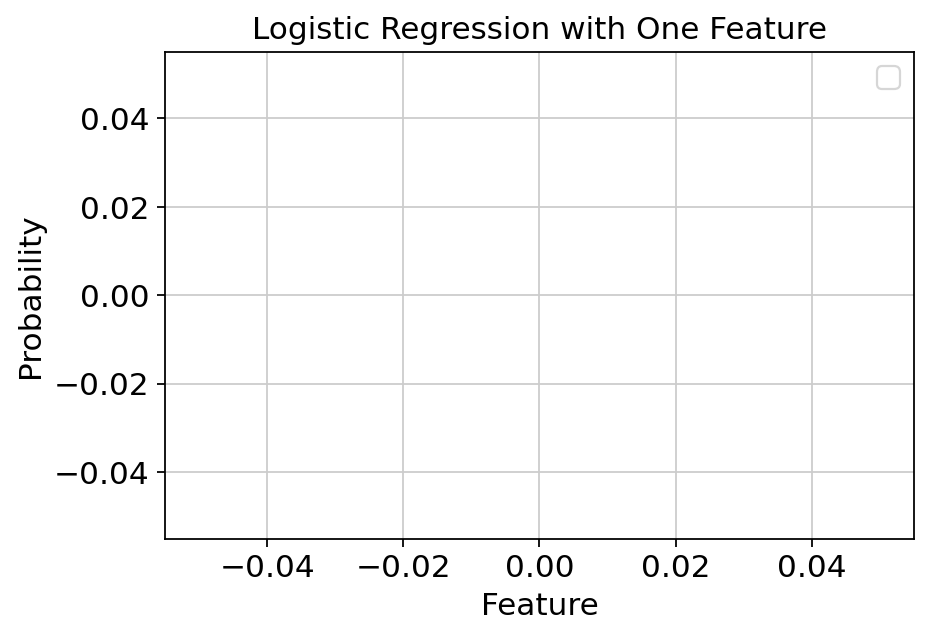

In [792]:
# Plot the feature against the predicted probabilities
x_values = x_values.flatten()
plt.scatter(X_train, y_train, marker='o', edgecolor='k')
# plt.plot(x_values, probabilities, label='Probability')

# Mark the decision boundary (where probability is 0.024 should be 0.5)
# decision_boundary = x_values[probabilities >= 0.5][0]
# plt.axvline(x=decision_boundary, color='red', linestyle='--', label=f'Decision Boundary ({decision_boundary:.2f})')

# Plot the original data points


plt.xlabel('Feature')
plt.ylabel('Probability')
plt.title('Logistic Regression with One Feature')
plt.legend()
plt.show()

The distribution of points doesn't look like they cluster into a specific zone, 
so a logistic regression probably won't work very well.
As you can see in the widget below:

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from ipywidgets import interact

def plot_logistic_regression(std_dev=0.1, mean1 = 0.001, mean2 = 0.02):
    # Generating synthetic data
    np.random.seed(0)
    x1 = np.random.normal(mean1, std_dev, 100).reshape(-1, 1)
    y1 = np.ones(100)
    x2 = np.random.normal(mean2, std_dev, 100).reshape(-1, 1)
    y2 = np.zeros(100)

    X = np.vstack((x1, x2))
    y = np.concatenate((y1, y2))

    # Fit logistic regression model
    model = LogisticRegression()
    model.fit(X, y)

    # Create a range for plotting decision boundary
    x_min, x_max = X.min() - 1, X.max() + 1
    x_range = np.linspace(x_min, x_max, 300).reshape(-1, 1)
    y_probs = model.predict_proba(x_range)[:, 1]

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.scatter(x1, y1, color='red', label='Class 1')
    plt.scatter(x2, y2, color='blue', label='Class 0')
    plt.plot(x_range, y_probs, color='black', label='Decision Boundary')
    plt.xlabel('Feature')
    plt.ylabel('Probability')
    plt.title('Logistic Regression with Standard Deviation = {}'.format(std_dev))
    plt.legend()
    plt.show()

# Create interactive plot
interact(plot_logistic_regression, std_dev=(0.1, 2.0, 0.1), mean1=(-2.0, 2.0, 0.1), mean2=(-2.0, 2.0, 0.1))


interactive(children=(FloatSlider(value=0.1, description='std_dev', max=2.0, min=0.1), FloatSlider(value=0.001…

<function __main__.plot_logistic_regression(std_dev=0.1, mean1=0.001, mean2=0.02)>

Experimenting with the widget we can see that the adjusted curve becomes very big when the points are very near each other.

/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Normal       0.97      1.00      0.99     39414
       Tumor       0.00      0.00      0.00      1091

    accuracy                           0.97     40505
   macro avg       0.49      0.50      0.49     40505
weighted avg       0.95      0.97      0.96     40505



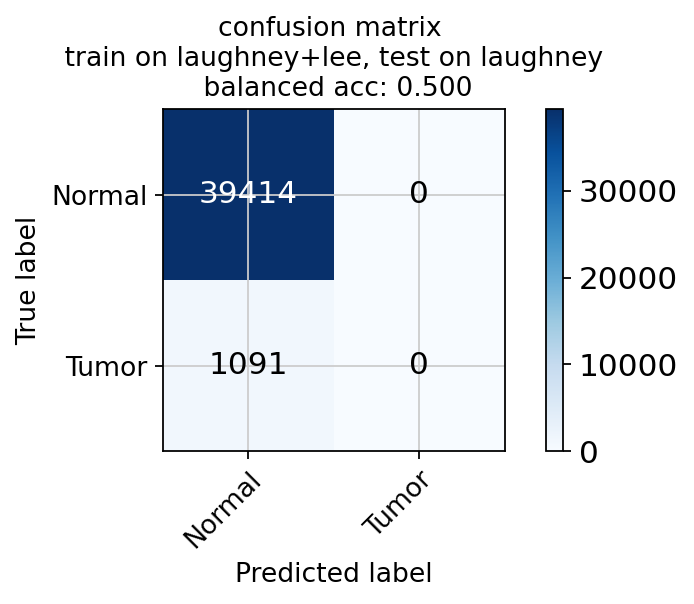

In [520]:
y = adata_laughney.obs['tier_0_hallmark_corrected']
y_pred_lr = final_cnv_correct_net

acc = metrics.balanced_accuracy_score(y, y_pred_lr)
print(metrics.classification_report(y, y_pred_lr, labels=["Normal", "Tumor"]))
fig, ax = plot_confusion_matrix(
    y,
    y_pred_lr,
    classes=["Normal", "Tumor"],
    title=f"confusion matrix \n train on laughney+lee, test on laughney \n balanced acc: {acc:.3f}",
)
fig.tight_layout()




## scFusion

`scFusion` is a computational pipeline for detecting gene fusions at single-cell resolution. scFusion works on Linux/Mac OS.

`scFusion` requires this data, that we must download ourselves:


    - Single cell RNA sequencing files from Smart-Seq protocol. File names should be _1.fastq, _2.fastq (e.g. 1_1.fastq, 1_2.fastq, 2_1.fastq, 2_2.fastq) ** *_1.fq is not allowed.

    - Reference genome file (*.fa)(like hg19.fa, file size = ~3G)

    - GTF annotation file (*.gtf) (Can be obtained from Ensembl (ftp://ftp.ensembl.org/pub/), NCBI, or UCSC)

    - (Optional) Mappabilityfile (Can be obtained from UCSC) If you are using the hg38 version of mappability file, please ensure the file format is the same as hg19's. (Only 4 columns. chr, start, end, value) If you do not provide this file, scFusion will turn off the mappability filter.


- For the fastq files we used a snakemake workflow that requires an `SraRuntable.csv` in its `config` folder.

  It is desgined only for paired reads of hg38 assembly, and > v2 chemistry (the chemistry changes the format and number of the files). This is the link to the repo:
https://github.com/hreypar/snake-sra-download.

  The `SraRuntable.csv` was queried from https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA510249.
Specfically, we excluded the mouse samples 
(A [link](https://www.ncbi.nlm.nih.gov/Traces/study/?acc=PRJNA510249&f=source_name_sam_ss%3An%3Apatient%2520primary%2520lung%2520adenocarcinoma%2Cpatient%2520adjacent%2520non-tumour%2520involved%2520lung%2Cpatient%2520primary%2520lung%2520adenocarcinoma%2520metastasis%2520to%2520brain%2Cpatient%2520primary%2520lung%2520adenocarcinoma%2520metastasis%2520to%2520bone%2Cpatient%2520primary%2520lung%2520adenocarcinoma%2520metastasis%2520to%2520adrenal%3Ac&o=acc_s%3Aa&s=SRR8326069,SRR8326070,SRR8326071,SRR8326072,SRR8326073,SRR8326074,SRR8326075,SRR8326076,SRR8326077,SRR8326078,SRR8326079,SRR8326080,SRR8326081,SRR8326067,SRR8325963,SRR8325964,SRR8325965,SRR8325966,SRR8325967,SRR8325968,SRR8325969,SRR8325970,SRR8325995,SRR8325996,SRR8325997,SRR8325998,SRR8325999,SRR8326000,SRR8326001,SRR8326002,SRR8326019,SRR8326020,SRR8326021,SRR8326022,SRR8326023,SRR8326024,SRR8326025,SRR8326026,SRR8326068,SRR8325979,SRR8325980,SRR8325981,SRR8325982,SRR8325983,SRR8325984,SRR8325985,SRR8325986,SRR8326035,SRR8326036,SRR8326037,SRR8326038,SRR8326039,SRR8326040,SRR8326041,SRR8326042,SRR8326051,SRR8326052,SRR8326053,SRR8326054,SRR8326055,SRR8326056,SRR8326057,SRR8326058,SRR8326059,SRR8326060,SRR8326061,SRR8326062,SRR8326063,SRR8326064,SRR8326065,SRR8326066,SRR8325947,SRR8325948,SRR8325949,SRR8325950,SRR8325951,SRR8325952,SRR8325953,SRR8325954,SRR8325955,SRR8325956,SRR8325957,SRR8325958,SRR8325959,SRR8325960,SRR8325961,SRR8325962,SRR8325971,SRR8325972,SRR8325973,SRR8325974,SRR8325975,SRR8325976,SRR8325977,SRR8325978,SRR8325987,SRR8325988,SRR8325989,SRR8325990,SRR8325991,SRR8325992,SRR8325993,SRR8325994,SRR8326003,SRR8326004,SRR8326005,SRR8326006,SRR8326007,SRR8326008,SRR8326009,SRR8326010,SRR8326011,SRR8326012,SRR8326013,SRR8326014,SRR8326015,SRR8326016,SRR8326017,SRR8326018,SRR8326027,SRR8326028,SRR8326029,SRR8326030,SRR8326031,SRR8326032,SRR8326033,SRR8326034,SRR8326043,SRR8326044,SRR8326045,SRR8326046,SRR8326047,SRR8326048,SRR8326049,SRR8326050) to the selection).

- The reference genome we used was the generic one from UCSC and we downloaded it with this command:
`wget http://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz`

- We did the same for the annotation file, taking notice that the annotation for the chr's had to be the same e.g. chr1:
`https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/genes/hg38.knownGene.gtf.gz`

- We used the UMAP mappability for hg38 we chose the UMAP algorithm for uniqueness with 24-kmers using the UCSC [table browser](https://genome.ucsc.edu/cgi-bin/hgTables).
  The parameters can be seen in the following request that would download the exact file:
  
  ```bash
  curl 'https://genome.ucsc.edu/cgi-bin/hgTables' -X POST -H 'Origin: https://genome.ucsc.edu' -H 'Connection: keep-alive' --data-raw 'hgsid=1799560612_nTTmx6aRyOuNWimRdPHam1uQypcq&jsh_pageVertPos=0&clade=mammal&org=Human&db=hg38&hgta_group=map&hgta_track=umap&hgta_table=umap24&hgta_regionType=genome&position=chr2%3A25%2C160%2C915-25%2C168%2C903&hgta_outputType=primaryTable&boolshad.sendToGalaxy=0&boolshad.sendToGreat=0&hgta_outFileName=lo.txt&hgta_outSep=tab&hgta_compressType=none&hgta_doTopSubmit=get+output' > hg38mappability110.txt
  ```
-  We also had to transform the file to the desired format 
```
awk '$6 == "+" {print $1, $2, $3, $5}' ../scFusion/hg38mappability110.txt > ../scFusion/hg38mappability110_2.txt
sed -i 's/ /\t/g' ../scFusion/hg38mappability110_2.txt
```
  
  
*TODO: DO IT WITH THE RESTUFUL API or with `ucsc-genomic-api`*

In [19]:
adata.obs['patient'].astype(str) + '_' + adata.obs['origin'].astype(str)

120703408884123_0     LX682_tumor_primary
120703409633700_0     LX682_tumor_primary
120703423507166_0     LX682_tumor_primary
120703423561070_0     LX682_tumor_primary
120703436306869_0     LX682_tumor_primary
                             ...         
241114576481206_16           LX682_normal
241114577287974_16           LX682_normal
241114589031734_16           LX682_normal
241114589096668_16           LX682_normal
241114608782195_16           LX682_normal
Length: 42847, dtype: object

This are the steps we had to take to run the scFusion pipeline

```
#Aprox 40 min*
python scFusion.py BuildSTARIndex -g /datos/maestria/netopaas/scFusion/hg38.fa -a /datos/maestria/netopaas/scFusion/hg38.knownGene.gtf -s /datos/maestria/netopaas/scFusion/STAR -t 70

python scFusion.py Index -g /datos/maestria/netopaas/scFusion/hg38.fa -a /datos/maestria/netopaas/scFusion/hg38.knownGene.gtf -d /datos/maestria/netopaas/scFusion/scFusionIndex/

 find . -maxdepth 3 -type f -name "*.fastq.gz" --exec mv {} /datos/maestria/netopaas/scFusion/fastq/ \;

python scFusion.py Rename -f /datos/maestria/netopaas/scFusion/fastq/

 find . -name "*.gz" -print0 | xargs -0 -P 50 -I {} gunzip {}

# Beware of too many open files... use ulimit -n 5000. Took 120 min with adjustment to batch script*
python scFusion.py ReadMapping -f /datos/maestria/netopaas/scFusion/fastq/ -b 1 -e 122 -s /datos/maestria/netopaas/scFusion/STAR/ -o /datos/maestria/netopaas/scFusion/out/ -t 8
# Start 4.02 .apparently 3 min per cell D:
# Somewhat achievable with parallel processing but still very much around 20hrs when using 50 cores

ranges.txt hasthis form:
1 4
5 8
6 12
cat ranges.txt | xargs -P 16 -I {} sh -c 'python scFusion.py ReadProcessing -b $(echo {} | cut -f1 -d" ") -e $(echo {} | cut -f2 -d" ") -d ~/datos/maestria/netopaas/scFusion/scFusionIndex/ -o ~/datos/maestria/netopaas/scFusion/out/ -m ~/datos/maestria/netopaas/scFusion/hg38mappability110_2.txt'

# At least 40 hours per SRA
cat ranges.txt | xargs -P 16 -I {} sh -c 'python scFusion.py FusionCandidate -b $(echo {} | cut -f1 -d" ") -e $(echo {} | cut -f2 -d" ") -d ~/datos/maestria/netopaas/scFusion/scFusionIndex/ -o ~/datos/maestria/netopaas/scFusion/out/'


Stoped here:  File "/root/datos/maestria/netopaas/scFusionRepo/.//bin//FusionScore.py" line 244
```

In [14]:
for i in range(34,85,2):
    print(i,i+1)

34 35
36 37
38 39
40 41
42 43
44 45
46 47
48 49
50 51
52 53
54 55
56 57
58 59
60 61
62 63
64 65
66 67
68 69
70 71
72 73
74 75
76 77
78 79
80 81
82 83
84 85


In [ ]:
STAR --runThreadN 70 --runMode genomeGenerate --genomeDir /STAR --genomeFastaFiles hg38.fa --sjdbGTFfile Homo_sapiens.GRCh38.110.gtf --sjdbOverhang 149

## InferCNV

We abandoned this as infercnvpy is faster and easier to use.
First we must get the gene orderings

In [132]:
from pybiomart import Server

# Connect to the Ensembl biomart server
server = Server(host='http://www.ensembl.org')

# Select the appropriate dataset (e.g., human genes)
dataset = server.marts['ENSEMBL_MART_ENSEMBL'].datasets['hsapiens_gene_ensembl']

# Prepare the query
# Replace 'your_gene_symbols' with a list of your gene symbols
query = dataset.query(attributes=['external_gene_name', 'chromosome_name', 'start_position', 'end_position'])


# join_map_mart(query, adata_laughney.var , gene_annot='gene_symbol', how='inner')


AttributeError: 'function' object has no attribute 'index'

In [192]:

gene_order = pd.merge(
        pd.DataFrame({'Gene name':adata_laughney.var.index}),
        query,
        how='inner', on='Gene name', suffixes=('_xxx','_yyy'))
gene_order

Gene name Chromosome/scaffold name  Gene start (bp)  Gene end (bp)
0          A1BG                       19         58345178       58353492
1          A1CF                       10         50799409       50885675
2           A2M                       12          9067664        9116229
3         A2ML1                       12          8822621        8887001
4        A4GALT                       22         42692121       42721298
...         ...                      ...              ...            ...
18418    ZYG11B                        1         52726453       52827336
18419       ZYX              HG708_PATCH              659          10475
18420       ZYX                        7        143381295      143391111
18421     ZZEF1                       17          4004445        4143030
18422      ZZZ3                        1         77562416       77683419

[18423 rows x 4 columns]

There is an isse with the scaffolds, there are plenty and there are many repeated genes.
We must remove them

In [200]:
gene_order['Chromosome/scaffold name'].unique()

array(['19', '10', '12', '22', '3', '4', '15', '2', '11', '17', '20', '8',
       '6', '7', '16', '9', '1', 'X', '13', '14', '21', '18', '5', 'Y',
       'MT'], dtype=object)

In [223]:
%%R
system.file("extdata", "oligodendroglioma_expression_downsampled.counts.matrix.gz", package = "infercnv")

[1] "/opt/R/lib/R/library/infercnv/extdata/oligodendroglioma_expression_downsampled.counts.matrix.gz"


In [206]:
# Example of a custom criteria: keep the row with the maximum value in column 'B' for each group in column 'A'
gene_order = gene_order.groupby('Gene name')\
    .apply(lambda x: x[~ x['Chromosome/scaffold name'].str.contains('H')])\
    .reset_index(drop=True)

# After filtering for scaffolds we still have some duplicates so we dropthem
gene_order = gene_order.drop_duplicates('Gene name')

In [221]:
gene_order.to_csv('out/laughney_order.txt' , sep='\t', header=None, index=False)

Now let's get the cell type annotations first we see the format:

In [173]:
! head "/opt/R/lib/R/library/infercnv/extdata/oligodendroglioma_annotations_downsampled.txt"

MGH54_P2_C12	Microglia/Macrophage
MGH36_P6_F03	Microglia/Macrophage
MGH53_P4_H08	Microglia/Macrophage
MGH53_P2_E09	Microglia/Macrophage
MGH36_P5_E12	Microglia/Macrophage
MGH54_P2_H07	Microglia/Macrophage
MGH36_P4_H06	Microglia/Macrophage
MGH53_P1_C01	Microglia/Macrophage
MGH36_P4_A10	Microglia/Macrophage
MGH36_P3_D10	Microglia/Macrophage


and we save it as such:

In [178]:
adata_laughney.obs[['ascend','CELL_TYPE']].to_csv('out/type_annots.txt',
                                                  sep='\t',
                                                  header=None,
                                                  index=None)
! head 'out/type_annots.txt'

0	Tm
1	MACROPHAGE
2	DENDRITIC
3	Tm
4	Tm
5	Tm
6	Tm
7	Tm
8	NKT
9	Tm


These are the main considerations when running inferCNV:

    Note, if you do not have reference cells, you can set ref_group_names=NULL, in which case the average signal across all cells will be used to define the baseline. This can work well when there are sufficient differences among the cells included (ie. they do not all show a chromosomal deletion at the same place).

    Note, inferCNV expects that you've already filtered out low quality cells. If you need to further impose minimum/maximum read counts per cell, you can include an additional filter, such as: min_max_counts_per_cell=c(1e5,1e6)


The data matrix must have the following format:

In [230]:
! zcat /opt/R/lib/R/library/infercnv/extdata/oligodendroglioma_expression_downsampled.counts.matrix.gz | head -n 3

MGH54_P16_F12	MGH54_P12_C10	MGH54_P11_C11	MGH54_P15_D06	MGH54_P16_A03	MGH53_P7_B09	MGH54_P10_G04	MGH53_P2_A02	MGH53_P7_F07	MGH53_P5_G02	MGH53_P11_H03	MGH53_P1_A10	MGH53_P5_H09	MGH53_P11_E03	MGH53_P10_F11	MGH53_P1_D07	MGH53_P2_G04	MGH53_P2_G09	MGH53_P5_F04	MGH53_P11_F08	MGH53_P8_F03	MGH53_P6_B11	MGH53_P6_H06	MGH54_P2_C12	MGH36_P6_F03	MGH53_P4_H08	MGH53_P2_E09	MGH36_P5_E12	MGH54_P2_H07	MGH36_P4_H06	MGH53_P1_C01	MGH36_P4_A10	MGH36_P3_D10	MGH54_P2_F09	MGH36_P7_H06	MGH54_P2_H03	MGH36_P8_A02	MGH53_P2_C08	MGH53_P2_A07	MGH53_P1_F10	MGH36_P3_H06	MGH54_P2_F03	MGH36_P10_B08	MGH36_P9_H03	MGH36_P6_C04	MGH36_P2_G01	MGH36_P10_C10	MGH36_P5_B08	MGH36_P4_B09	MGH36_P4_G03	MGH36_P7_D03	MGH36_P3_B02	MGH36_P7_G04	MGH36_P4_D11	MGH36_P1_H10	MGH36_P5_H05	MGH36_P2_G02	MGH36_P7_F04	MGH36_P7_B04	MGH36_P6_G08	MGH36_P2_A08	MGH36_P3_C04	MGH36_P5_F05	MGH36_P1_B02	MGH36_P8_H09	MGH36_P5_F11	MGH36_P2_H06	MGH36_P2_C02	MGH36_P10_E07	MGH36_P3_A09	MGH36_P8_E05	MGH36_P9_B11	MGH36_P9_B01	MGH36_P3_E06	MGH36_P10_F09	MGH53_P12_C

In [235]:
adata_laughney.layers['norm'] = adata_laughney.X
adata_laughney.X = adata_laughney.layers['counts']

infer_counts = adata_laughney.to_df().T

In [236]:
%%R -i infer_counts -o infercnv_obj
library(infercnv)

infercnv_obj = CreateInfercnvObject(raw_counts_matrix=infer_counts,
                                    annotations_file='out/type_annots.txt',
                                    delim="\t",
                                    gene_order_file='out/laughney_order.txt',
                                    ref_group_names=NULL)

infercnv_obj = infercnv::run(infercnv_obj,
                             cutoff=0.1, # cutoff=1 works well for Smart-seq2, and cutoff=0.1 works well for 10x Genomics
                             out_dir=tempfile(), 
                             cluster_by_groups=TRUE, 
                             denoise=TRUE,
                             HMM=TRUE)


INFO [2023-11-20 20:13:26] Parsing gene order file: out/laughney_order.txt
INFO [2023-11-20 20:13:27] Parsing cell annotations file: out/type_annots.txt
INFO [2023-11-20 20:13:27] ::order_reduce:Start.
INFO [2023-11-20 20:13:31] .order_reduce(): expr and order match.
INFO [2023-11-20 20:13:36] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 19222,40505 Total=299912321 Min=0 Max=29818.
INFO [2023-11-20 20:13:38] num genes removed taking into account provided gene ordering list: 3054 = 15.8880449484965% removed.
INFO [2023-11-20 20:13:41] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-11-20 20:13:49] Please use "options(scipen = 100)" before running infercnv if you are using the analysis_mode="subclusters" option or you may encounter an error while the hclust is being generated.
INFO [2023-11-20 20:14:23] validating infercnv_obj
INFO [2023-11-20 20:14:23] ::process_data:Start
INFO [2023-11-20 20:14:23] Creating output path /tmp/Rt

RInterpreterError: Failed to parse and evaluate line 'library(infercnv)\n\ninfercnv_obj = CreateInfercnvObject(raw_counts_matrix=adata_counts,\n                                    annotations_file=\'out/type_annots.txt\',\n                                    delim="\\t",\n                                    gene_order_file=\'out/laughney_order.txt\',\n                                    ref_group_names=NULL)\n\ninfercnv_obj = infercnv::run(infercnv_obj,\n                             cutoff=0.1, # cutoff=1 works well for Smart-seq2, and cutoff=0.1 works well for 10x Genomics\n                             out_dir=tempfile(), \n                             cluster_by_groups=TRUE, \n                             denoise=TRUE,\n                             HMM=TRUE)\n'.
R error message: 'Error in ScaleData(object = object[[assay]], features = features, vars.to.regress = vars.to.regress,  :'
R stdout:
Warning: Data is of class matrix. Coercing to dgCMatrix.
Finding variable features for layer counts
Calculating gene variances
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Calculating feature variances of standardized and clipped values
0%   10   20   30   40   50   60   70   80   90   100%
[----|----|----|----|----|----|----|----|----|----|
**************************************************|
Warning: No layers found matching search pattern provided

In [247]:
%%R
str(infercnv_obj)

Formal class 'infercnv' [package "infercnv"] with 8 slots
  ..@ expr.data                       : num [1:16168, 1:40505] 0 0 0 0 0 0 0 0 0 1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:16168] "PLPP2" "MIER2" "THEG" "C2CD4C" ...
  .. .. ..$ : chr [1:40505] "0" "1" "2" "3" ...
  ..@ count.data                      : num [1:16168, 1:40505] 0 0 0 0 0 0 0 0 0 1 ...
  .. ..- attr(*, "dimnames")=List of 2
  .. .. ..$ : chr [1:16168] "PLPP2" "MIER2" "THEG" "C2CD4C" ...
  .. .. ..$ : chr [1:40505] "0" "1" "2" "3" ...
  ..@ gene_order                      :'data.frame':	16168 obs. of  3 variables:
  .. ..$ chr  : Factor w/ 25 levels "19","10","12",..: 1 1 1 1 1 1 1 1 1 1 ...
  .. ..$ start: int [1:16168] 281040 305573 361747 405445 416589 489176 507497 531760 544034 571277 ...
  .. ..$ stop : int [1:16168] 291403 344815 376026 409147 461033 505343 519654 542092 549924 583494 ...
  ..@ reference_grouped_cell_indices  : list()
  ..@ observation_grouped_cell_indices:List of 20
 